In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/sample (1).csv
/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv
/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/movies.csv (1)/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/train.csv (1)/train.csv


In [2]:
#importing the relevant modules

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay,auc
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.svm import LinearSVC
from scipy import sparse
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV


import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import warnings
warnings.filterwarnings('ignore')


/tmp/ipykernel_20/1193998667.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# **Exploring Movies Dataset**

In [3]:
movies_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/movies.csv (1)/movies.csv')
movies_df.head()

movieid  \
0                  han_solo_heroic_myth_wonder_woman   
1              voyage_tyler_durden_han_solo_stardust   
2  norman_bates_ferris_bueller_hermione_granger_v...   
3                           elegant_hermione_granger   
4                             adventure_rocky_balboa   

                                               title  audienceScore rating  \
0                  Han Solo Heroic Myth Wonder Woman           50.0    NaN   
1              Voyage Tyler Durden Han Solo Stardust            NaN    NaN   
2  Norman Bates Ferris Bueller Hermione Granger V...           43.0    NaN   
3                           Elegant Hermione Granger           60.0    NaN   
4                             Adventure Rocky Balboa           70.0    NaN   

  ratingContents releaseDateTheaters releaseDateStreaming  runtimeMinutes  \
0            NaN                 NaN           2018-08-25            75.0   
1            NaN                 NaN           2020-02-11           114.0   
2            NaN                 NaN                  NaN           120.0   
3            NaN                 NaN           2020-10-23            90.0   
4            NaN                 NaN           2017-03-27            80.0   

                           genre originalLanguage        director boxOffice  \
0         Comedy, Horror, Sci-fi          English  Claude Nicolet       NaN   
1                          Drama          English    Nathan Haack       NaN   
2                          Drama           Korean   Theresa Smith       NaN   
3     Action, Mystery & thriller          English    Donald Lewis       NaN   
4  Fantasy, Adventure, Animation          English    Howard Simms       NaN   

  distributor soundType  
0         NaN       NaN  
1         NaN       NaN  
2         NaN       NaN  
3         NaN       NaN  
4         NaN       NaN

In [4]:
print('Shape of the movies dataset:', movies_df.shape)

Shape of the movies dataset: (143258, 14)


## Glance of the Movies Dataset

In [5]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23001 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


## Checking for Null values

In [6]:
# checking for null values in the movies dataset

(movies_df.isna().sum()/movies_df.shape[0])*100

movieid                  0.000000
title                    0.000000
audienceScore           48.869871
rating                  90.233704
ratingContents          90.233704
releaseDateTheaters     78.519175
releaseDateStreaming    44.561560
runtimeMinutes           9.651817
genre                    7.736392
originalLanguage         9.673456
director                 0.000000
boxOffice               89.708777
distributor             83.944352
soundType               88.889277
dtype: float64

## Removing columns with too many null values

In [7]:
# removing the columns with null values more than 70 percent

movies_df.drop(columns=['title', 'rating', 'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming',
              'boxOffice', 'distributor', 'soundType'], inplace=True)
movies_df.head()

movieid  audienceScore  \
0                  han_solo_heroic_myth_wonder_woman           50.0   
1              voyage_tyler_durden_han_solo_stardust            NaN   
2  norman_bates_ferris_bueller_hermione_granger_v...           43.0   
3                           elegant_hermione_granger           60.0   
4                             adventure_rocky_balboa           70.0   

   runtimeMinutes                          genre originalLanguage  \
0            75.0         Comedy, Horror, Sci-fi          English   
1           114.0                          Drama          English   
2           120.0                          Drama           Korean   
3            90.0     Action, Mystery & thriller          English   
4            80.0  Fantasy, Adventure, Animation          English   

         director  
0  Claude Nicolet  
1    Nathan Haack  
2   Theresa Smith  
3    Donald Lewis  
4    Howard Simms

In [8]:
print('Shape of the movies dataset after removing columns:',movies_df.shape)

Shape of the movies dataset after removing columns: (143258, 6)


## Removing duplicate rows

In [9]:
# dropping duplicates from the movies dataset

movies_df.drop_duplicates(inplace = True)
print('Shape after removing duplicates:',movies_df.shape)

Shape after removing duplicates: (141655, 6)


## Still duplicates exists in the Movies ID

In [10]:
movies_df['movieid'].value_counts()

movieid
escape_the_terminator_tyler_durden_astonish                   73
crimson_james_t._kirk_marty_mcfly_hulk                        17
silent_mystery_the_terminator                                 16
darth_vader_dazzling_courageous_holly_golightly               16
rocky_balboa_wonder_woman_majestic_emerald                    16
                                                              ..
legendary_silent_scarlett_o'hara                               1
don_vito_corleone_black_widow_edward_scissorhands_majestic     1
don_vito_corleone_superman_tony_stark                          1
sapphire_galaxy_spectacular                                    1
wonder_hermione_granger_hulk_v                                 1
Name: count, Length: 126404, dtype: int64

In [11]:
# Definning a custom mode function. Here if the mode exists return the first model (in case of more than modes), 
# otherwise return nan value

def most_freq(series):
  mode = series.mode()
  if not mode.empty: 
    return mode[0]
  else:
    return np.nan


## Using groupby to aggregating information

movies_df_tf = movies_df.groupby('movieid', sort = False, as_index = False).agg({'audienceScore':'mean', 'runtimeMinutes':'mean', 
                                'originalLanguage': most_freq,'genre': most_freq, 'director': most_freq})

## Sanity check to see if duplicates still exist in the Movies ID column

In [12]:
print('Number of duplicates in the movies dataset:',movies_df_tf.duplicated(subset = 'movieid').sum())

Number of duplicates in the movies dataset: 0


## Final Output of Movies Dataset

In [13]:
movies_df_tf.head()

movieid  audienceScore  \
0                  han_solo_heroic_myth_wonder_woman      50.000000   
1              voyage_tyler_durden_han_solo_stardust            NaN   
2  norman_bates_ferris_bueller_hermione_granger_v...      43.000000   
3                           elegant_hermione_granger      60.000000   
4                             adventure_rocky_balboa      39.666667   

   runtimeMinutes originalLanguage                       genre        director  
0       75.000000          English      Comedy, Horror, Sci-fi  Claude Nicolet  
1      114.000000          English                       Drama    Nathan Haack  
2      120.000000           Korean                       Drama   Theresa Smith  
3       90.000000          English  Action, Mystery & thriller    Donald Lewis  
4       81.333333          English          Adventure, Fantasy    Howard Simms

# **Exploring the Training Dataset**

In [14]:
train_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/train.csv (1)/train.csv')
train_df.head()

movieid         reviewerName  \
0                                   marvelous_pirate       Benjamin Henry   
1          tony_montana_frodo_baggins_v_rocky_balboa        Felicia Lopez   
2  darth_vader_katniss_everdeen_sorcerer_donnie_d...  Mr. Charles Burgess   
3                                 lara_croft_glimmer         Ryan Barrett   
4  jason_bourne_surreal_the_terminator_indiana_jones     Alexander Glover   

   isFrequentReviewer                                         reviewText  \
0               False  Henry Selick’s first movie since 2009’s Corali...   
1               False  With a cast that reads like the Vogue Oscar pa...   
2                True  Creed II does not give us anything but another...   
3               False  I know what you're thinking, but this is no Li...   
4               False  Director Fernando Meirelles tells the story wi...   

  sentiment  
0  POSITIVE  
1  NEGATIVE  
2  POSITIVE  
3  POSITIVE  
4  POSITIVE

In [15]:
print('Shape of the training dataset:',train_df.shape)

Shape of the training dataset: (162758, 5)


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


## Checking for Null values in the Training Dataset

In [17]:
(train_df.isnull().sum()/ train_df.shape[0])*100

movieid               0.000000
reviewerName          0.000000
isFrequentReviewer    0.000000
reviewText            3.961096
sentiment             0.000000
dtype: float64

## Merging Movies and Training Datasets

In [18]:
# merging the movies and training dataset based on inner join

merged_train_df = pd.merge(movies_df_tf, train_df, on='movieid', how='inner',sort=False)
merged_train_df.sample(5)

movieid  audienceScore  runtimeMinutes  \
35061                  ethereal_legend_enigma          58.00      116.000000   
55656          han_solo_magic_miracle_gandalf          50.00      125.000000   
17816                      vivid_jack_sparrow          69.25      110.400000   
17001  sherlock_holmes_pirate_sherlock_holmes          47.00       86.000000   
951                enigma_oracle_tony_stark_v          79.00       96.333333   

      originalLanguage                       genre         director  \
35061          English  Adventure, Action, Fantasy      Diane Olden   
55656          English          Fantasy, Adventure    Robin Ferraro   
17816          English                      Action  Angela Williams   
17001          English          Mystery & thriller     Cindy Snyder   
951            English                       Drama    Alfred Walker   

         reviewerName  isFrequentReviewer  \
35061     Wayne Adams               False   
55656    Tracey Jones                True   
17816  Wanda Peterson                True   
17001  Joshua Nichols                True   
951    Cynthia Martin               False   

                                              reviewText sentiment  
35061  The film is beautifully shot, courtesy of John...  POSITIVE  
55656  Those expecting an Arthurian sword-and-sandals...  POSITIVE  
17816  Offsetting its naughtier impulses with feel-go...  NEGATIVE  
17001  Is there anything scarier than a threatening t...  NEGATIVE  
951    A frequently hilarious look at a toxic, but od...  POSITIVE

In [19]:
print('Shape of merged_train_df', merged_train_df.shape)

Shape of merged_train_df (162758, 10)


# **Exploring the Testing Dataset**

In [20]:
test_df = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv')
test_df.head()

movieid     reviewerName  isTopCritic  \
0            legend_marty_mcfly_oracle         John Kim        False   
1  terminator_katniss_everdeen_glimmer     Brian Chaney        False   
2          james_bond_labyrinth_gollum  Danielle Parker        False   
3            v_quest_han_solo_wondrous    Brittany Lane        False   
4        enigma_hulk_surreal_starlight    Justin Willis        False   

                                          reviewText  
0  Green slowly cranks up the dread with style an...  
1  Philip Noyce's direction is elegant and unforc...  
2  It wouldn't do to say what path Maria ultimate...  
3  Pig is not exactly the arthouse John Wick that...  
4  An imaginative no-budget musical of sorts abou...

In [21]:
print('Shape of the testing dataset:',test_df.shape)

Shape of the testing dataset: (55315, 4)


## Glance of the Testing Dataset

In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


## Checking for the Null Values in the Testing Dataset

In [23]:
(test_df.isnull().sum()/ test_df.shape[0])*100

movieid         0.000000
reviewerName    0.000000
isTopCritic     0.000000
reviewText      4.537648
dtype: float64

## Merging the Movies and Testing Dataset

In [24]:
# merging the movies and testing dataset based on inner join

merged_test_df = pd.merge(movies_df_tf, test_df, on='movieid', how='inner', sort=False)
merged_test_df.sample(10)

movieid  audienceScore  \
8859    norman_bates_darth_vader_ferris_bueller_t-800      92.000000   
44151                     captain_jack_sparrow_dragon      66.000000   
20122  princess_leia_the_terminator_gollum_chronicles      50.000000   
17610              luke_skywalker_mystique_neo_velvet      61.666667   
43922       scarlett_o'hara_hulk_captain_jack_sparrow      58.000000   
11752            holly_golightly_captain_jack_sparrow      74.000000   
44614                    neo_katniss_everdeen_enchant      76.000000   
49085                            magic_wonder_gandalf      91.000000   
5473         enigma_wolverine_enchanted_james_t._kirk      48.000000   
13533   kingdom_spectacular_tyler_durden_john_mcclane      86.000000   

       runtimeMinutes originalLanguage  \
8859            121.0          English   
44151           183.0          English   
20122            81.0          English   
17610           111.0          English   
43922            93.0          English   
11752           159.0          English   
44614            96.0          English   
49085            84.0          English   
5473            103.0          English   
13533            80.0          English   

                                            genre            director  \
8859   Sci-fi, Adventure, Action, Fantasy, Comedy    Frank Rautenberg   
44151                                  War, Drama    Catherine Fouche   
20122                                      Comedy       Joseph Brooks   
17610                                      Action       David Carasco   
43922                          Documentary, Music         Carolyn Mai   
11752                                       Drama       David Copland   
44614          Drama, Mystery & thriller, Romance      Merlene Burgos   
49085                                      Comedy         Verna Flood   
5473                          Documentary, Lgbtq+  Patricia Mcclaskey   
13533                                       Drama      Troy Diederich   

              reviewerName  isTopCritic  \
8859          Megan Benson        False   
44151     Rachel Mills DVM         True   
20122         Anna Camacho        False   
17610      Virginia Miller         True   
43922         Daisy Harris        False   
11752    Jeffrey Patterson        False   
44614  Stephanie Obrien MD        False   
49085        Claire Conway        False   
5473        Tyler Marshall         True   
13533         Melanie Rios        False   

                                              reviewText  
8859   If Boyhood is a reminder of film's potential t...  
44151  Pearl Harbor is a blockheaded, hollow-hearted ...  
20122          [A] contrived but pleasant enough comedy.  
17610  Man on Fire plays it out to the bloody end, li...  
43922  The documentary manages to show the ups and do...  
11752  Slowly but surely wrapped around me and put me...  
44614  A simple and surprisingly affecting love story...  
49085                                                NaN  
5473   Although the movie isn't without merit, it's a...  
13533  ...an indelible and intimate film that capture...

In [25]:
print('Shape of the merged_test_df:',merged_test_df.shape)

Shape of the merged_test_df: (55315, 9)


# **Exploratory Data Analysis**

In [26]:
# creating a copy of merged_train for the purpose of EDA

merged_train_df_copy = merged_train_df.copy()
merged_train_df_copy.head()

movieid  audienceScore  runtimeMinutes originalLanguage  \
0  james_bond_courageous      49.333333            82.2          English   
1  james_bond_courageous      49.333333            82.2          English   
2  james_bond_courageous      49.333333            82.2          English   
3  james_bond_courageous      49.333333            82.2          English   
4  james_bond_courageous      49.333333            82.2          English   

   genre   director    reviewerName  isFrequentReviewer  \
0  Drama  Brian Mew  Karen Hamilton               False   
1  Drama  Brian Mew    Jessica Best               False   
2  Drama  Brian Mew   Rebekah Gomez               False   
3  Drama  Brian Mew   Paul Sullivan               False   
4  Drama  Brian Mew   Stacey Malone                True   

                                          reviewText sentiment  
0  This is nowhere near the level of other great ...  POSITIVE  
1  If you're feeling adventurous and looking for ...  POSITIVE  
2  Mercifully, Vincent Cassel provides a strong l...  POSITIVE  
3  Like the storm that destroys the best laid pla...  POSITIVE  
4  Less a proper coming-of-age movie than a posh ...  NEGATIVE

In [27]:
# checking for null values

(merged_train_df_copy.isnull().sum()/merged_train_df.shape[0])*100

movieid               0.000000
audienceScore         1.742464
runtimeMinutes        0.455892
originalLanguage      0.446061
genre                 0.320107
director              0.000000
reviewerName          0.000000
isFrequentReviewer    0.000000
reviewText            3.961096
sentiment             0.000000
dtype: float64

In [28]:
# filling the null values

imputation = ColumnTransformer([
    ('si_numeric', SimpleImputer(), ['audienceScore','runtimeMinutes']),
    ('si_catgroical', SimpleImputer(strategy = 'most_frequent'), ['originalLanguage','genre', 'reviewText']),
     ('label_encoder', OneHotEncoder(sparse=False, drop='first', dtype=np.int64 ), ['isFrequentReviewer'])
    ], remainder='passthrough', verbose_feature_names_out=False)

merged_train_df_copy = pd.DataFrame(imputation.fit_transform(merged_train_df_copy), columns=imputation.get_feature_names_out())

In [29]:
merged_train_df_copy['reviewLength'] = merged_train_df_copy['reviewText'].apply(lambda x: len(x))
merged_train_df_copy.head()

audienceScore runtimeMinutes originalLanguage  genre  \
0     49.333333           82.2          English  Drama   
1     49.333333           82.2          English  Drama   
2     49.333333           82.2          English  Drama   
3     49.333333           82.2          English  Drama   
4     49.333333           82.2          English  Drama   

                                          reviewText isFrequentReviewer_True  \
0  This is nowhere near the level of other great ...                       0   
1  If you're feeling adventurous and looking for ...                       0   
2  Mercifully, Vincent Cassel provides a strong l...                       0   
3  Like the storm that destroys the best laid pla...                       0   
4  Less a proper coming-of-age movie than a posh ...                       1   

                 movieid   director    reviewerName sentiment  reviewLength  
0  james_bond_courageous  Brian Mew  Karen Hamilton  POSITIVE           164  
1  james_bond_courageous  Brian Mew    Jessica Best  POSITIVE           114  
2  james_bond_courageous  Brian Mew   Rebekah Gomez  POSITIVE            56  
3  james_bond_courageous  Brian Mew   Paul Sullivan  POSITIVE           145  
4  james_bond_courageous  Brian Mew   Stacey Malone  NEGATIVE            71

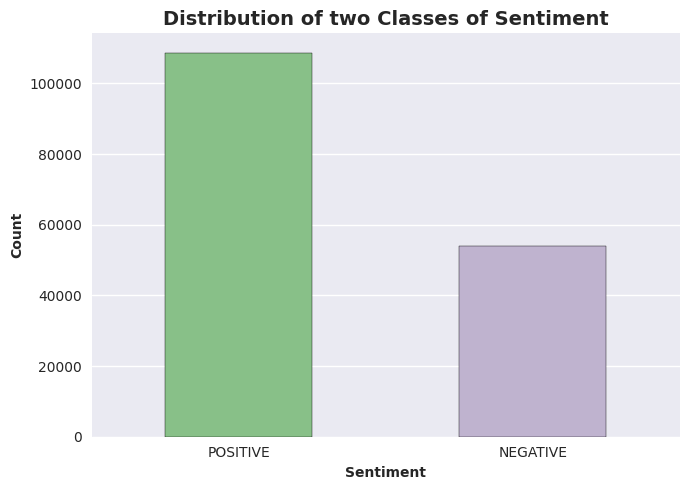

In [30]:
# checking the distribution of the label classes

plt.figure(figsize=(7,5))
sns.countplot(merged_train_df_copy, x = merged_train_df_copy['sentiment'], edgecolor='black', palette='Accent', width=0.5)
plt.xlabel('Sentiment', fontweight='bold', fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.title('Distribution of two Classes of Sentiment', fontweight='bold', fontsize=14)
plt.tight_layout();

## Insights

#### From the above countplot, we can infer that distribution is imbalanced. Positive class is almost twice more than the negative class.

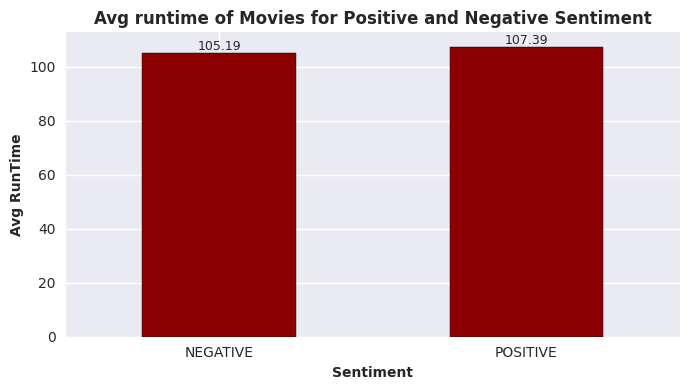

In [31]:
# grouping the runtime by sentiment and rounding off the values by 2 

data_grouped = merged_train_df_copy.groupby('sentiment')['runtimeMinutes'].mean()
data_grouped_list = [round(x,2) for x in data_grouped.values.tolist()]

# plotting the graph
plt.figure(figsize=(7,4))
data_barplot = data_grouped.plot(kind='bar', color='darkred', edgecolor='black')

for indx,val in enumerate(data_grouped_list):
    data_barplot.text(indx,val, str(val), ha='center', va='bottom', fontsize=9)
 
plt.xticks(rotation=360)
plt.title('Avg runtime of Movies for Positive and Negative Sentiment', fontweight='bold', fontsize=12)
plt.xlabel('Sentiment', fontweight='bold', fontsize=10)
plt.ylabel('Avg RunTime', fontweight='bold', fontsize=10)
plt.tight_layout();

## Insights

#### Average Runtime of movies of belonging to positive class is only slightly higher than runtime of movies of the negative class. It means runtime of movies do not impact sentiment by much.

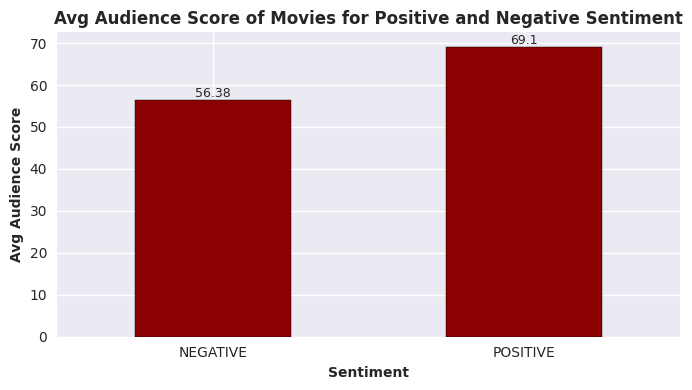

In [32]:
# grouping the audience score by sentiment and rounding off the values by 2 

data_grouped = merged_train_df_copy.groupby('sentiment')['audienceScore'].mean()
data_grouped_list = [round(x,2) for x in data_grouped.values.tolist()]

# plotting the graph

plt.figure(figsize=(7,4))
data_barplot = data_grouped.plot(kind='bar', color='darkred', edgecolor='black')

for indx,val in enumerate(data_grouped_list):
    data_barplot.text(indx,val, str(val), ha='center', va='bottom', fontsize=9)
 
plt.xticks(rotation=360)
plt.title('Avg Audience Score of Movies for Positive and Negative Sentiment', fontweight='bold', fontsize=12)
plt.xlabel('Sentiment', fontweight='bold', fontsize=10)
plt.ylabel('Avg Audience Score', fontweight='bold', fontsize=10)
plt.tight_layout();

## Insights

#### Average audience score of movies belonging to the positive class is significantly more than avg audience score of movies belonging to the negative class. The score differs by the almost 12.

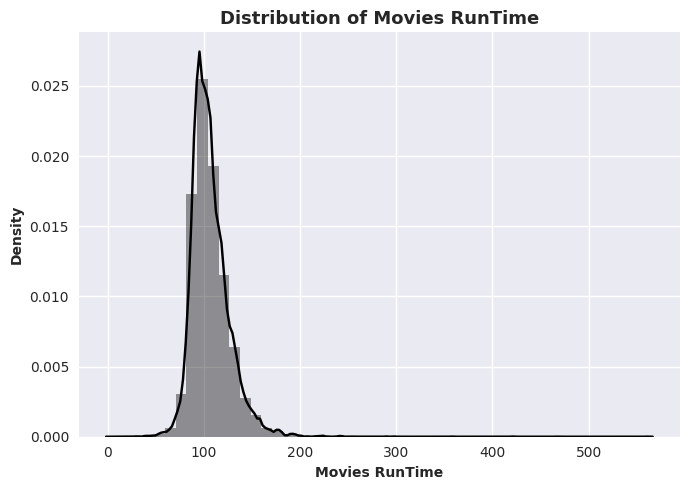

In [33]:
# distribution of runtime

plt.figure(figsize=(7,5))
sns.distplot(merged_train_df_copy['runtimeMinutes'], color='black')
plt.title('Distribution of Movies RunTime', fontweight='bold', fontsize=13)
plt.xlabel('Movies RunTime', fontweight='bold', fontsize=10)
plt.ylabel('Density', fontweight='bold', fontsize=10)
plt.tight_layout();

## Insights

#### Most movies have the runtime around 100. However, there are some outliers present in the column.

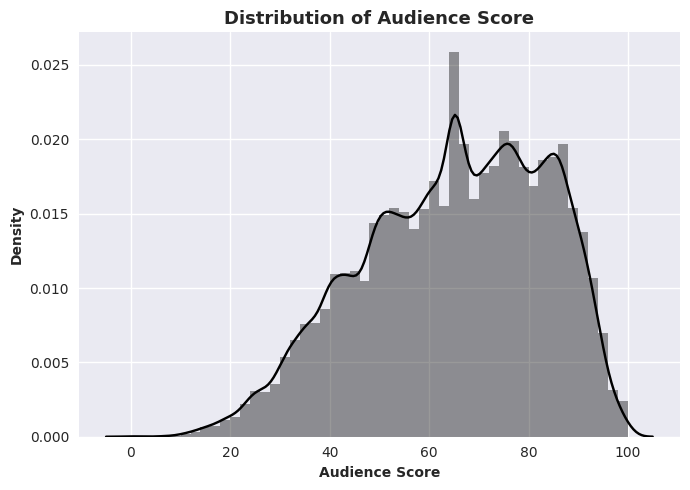

In [34]:
# distribution of audience score

plt.figure(figsize=(7,5))
sns.distplot(merged_train_df_copy['audienceScore'], color='black')
plt.title('Distribution of Audience Score', fontweight='bold', fontsize=13)
plt.xlabel('Audience Score', fontweight='bold', fontsize=10)
plt.ylabel('Density', fontweight='bold', fontsize=10)
plt.tight_layout();

## Insights

#### The Audience Score of the most movies is between 60-80. Moreover, there are quite a few outliers present here.

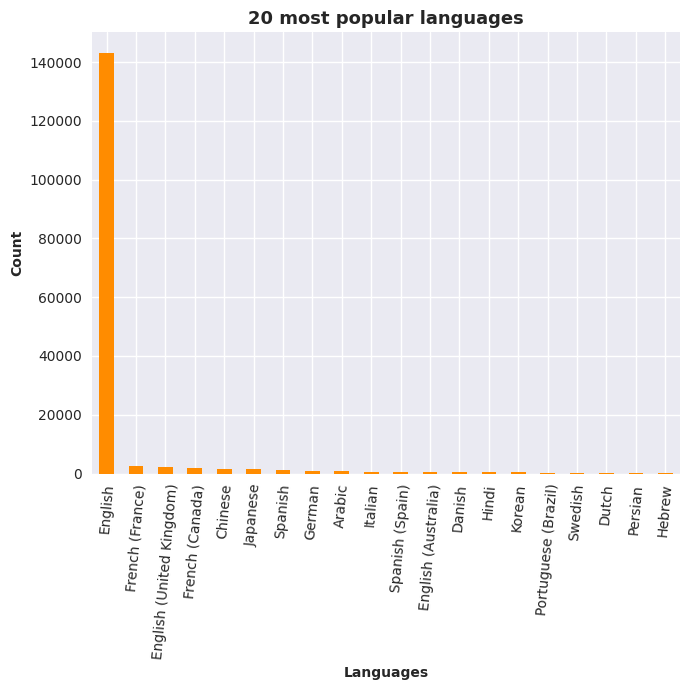

In [35]:
# most popular languages

plt.figure(figsize=(7,7))
data = merged_train_df_copy['originalLanguage'].value_counts().head(20)
data.plot(kind='bar', color='darkorange')
plt.title('20 most popular languages', fontweight='bold', fontsize=13)
plt.xlabel('Languages', fontweight='bold', fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.xticks(rotation=85)
plt.tight_layout();

## Insights

#### English by far is the most popular language among the viewers followed by French, Chinses, Japanese. One thing to note here is the difference between the first and second is almost 90%.

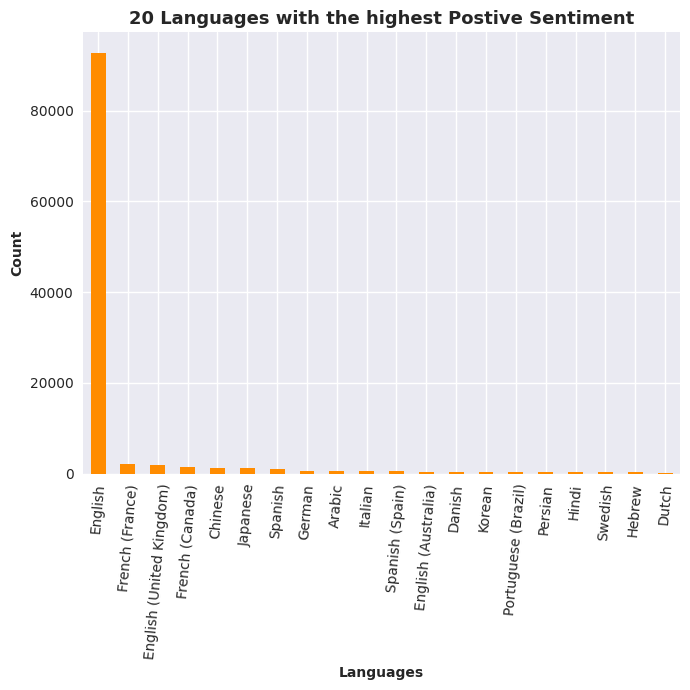

In [36]:
# filtering the dataset by positive sentiment and finding the most popular languages

filter_condition = merged_train_df_copy[merged_train_df_copy['sentiment'] == 'POSITIVE']
data = filter_condition.groupby('originalLanguage')['sentiment'].count().sort_values(ascending=False).head(20)

# plotting the graph

plt.figure(figsize=(7,7))
data.plot(kind='bar', color='darkorange')
plt.title('20 Languages with the highest Postive Sentiment', fontweight='bold', fontsize=13)
plt.xlabel('Languages', fontweight='bold', fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.xticks(rotation=85)
plt.tight_layout();

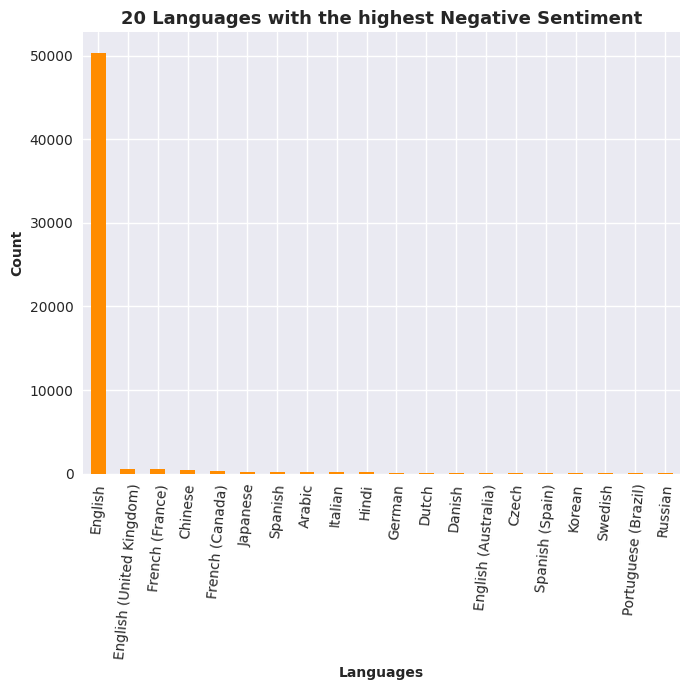

In [37]:
# filtering the dataset by negative sentiment and finding the most popular languages

filter_condition = merged_train_df_copy[merged_train_df_copy['sentiment'] == 'NEGATIVE']
data = filter_condition.groupby('originalLanguage')['sentiment'].count().sort_values(ascending=False).head(20)

# plotting the graph

plt.figure(figsize=(7,7))
data.plot(kind='bar', color='darkorange')
plt.title('20 Languages with the highest Negative Sentiment', fontweight='bold', fontsize=13)
plt.xlabel('Languages', fontweight='bold', fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.xticks(rotation=85)
plt.tight_layout();

# Insights

#### English which is the most popular language occupy the first spot in the languages with highest positive and negative sentiment, followed by French and Chinese

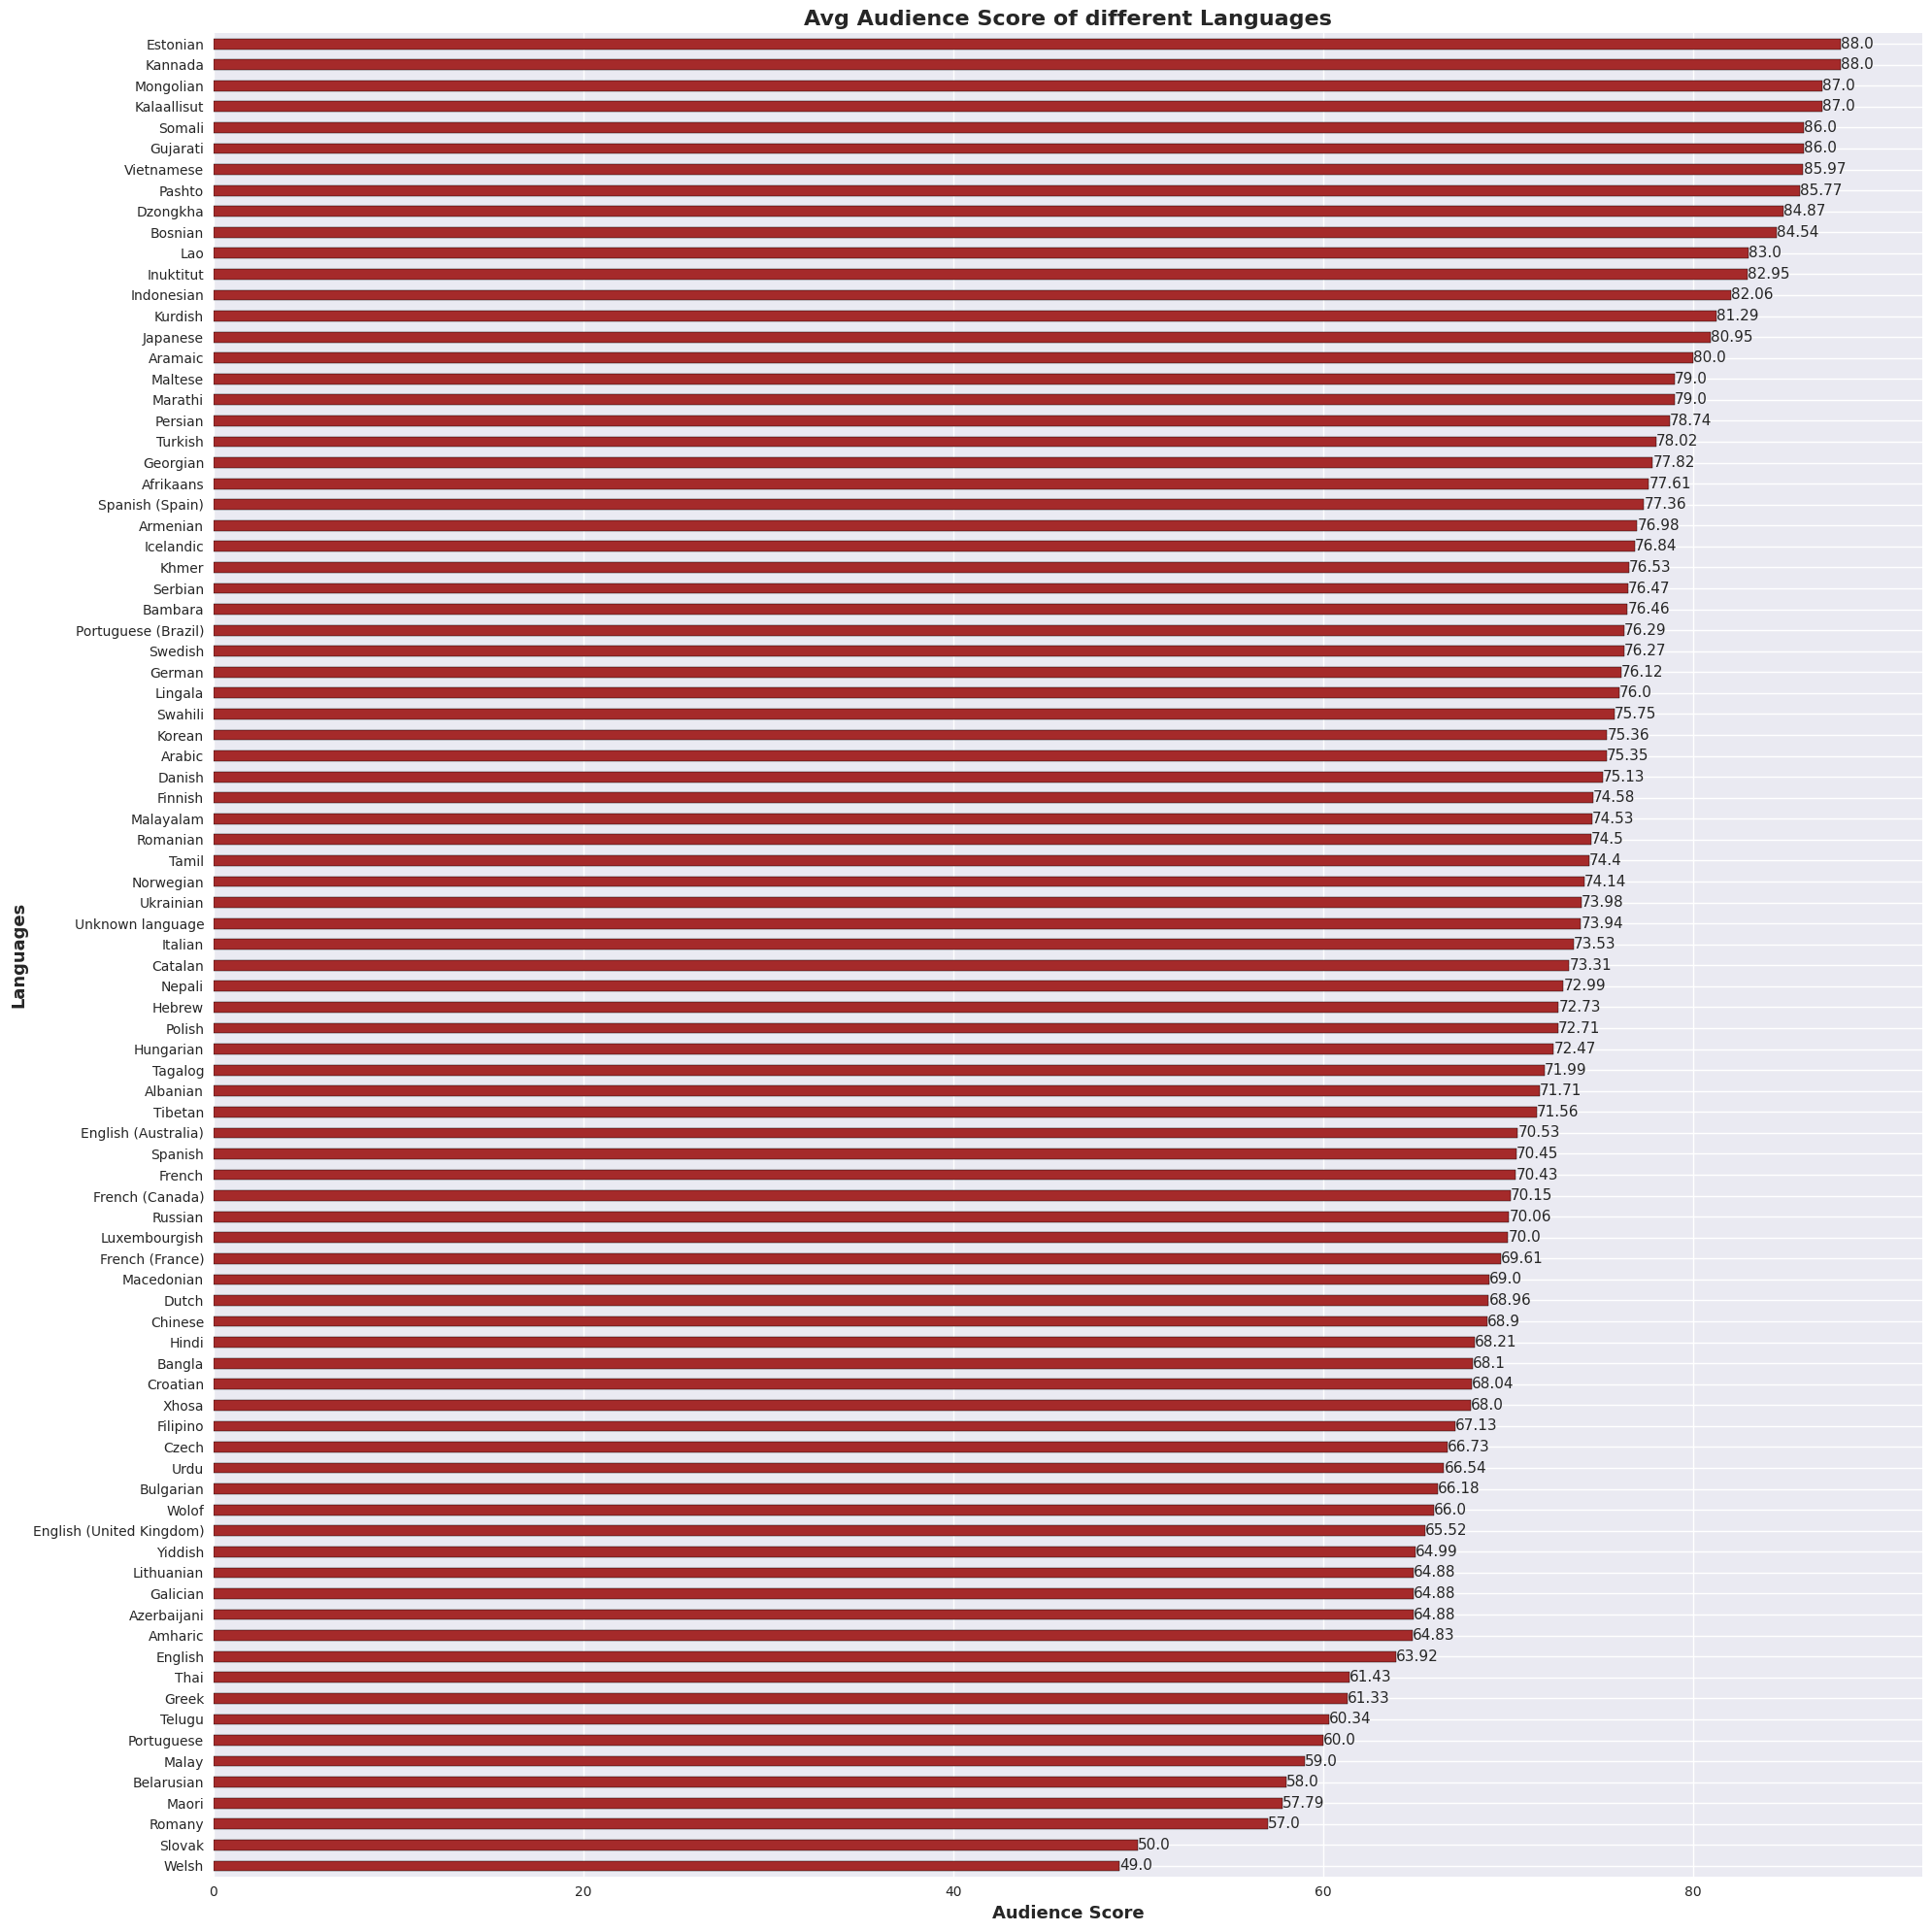

In [38]:
# grouping original language by audience score and rounding off the values by 2 

data_grouped  = merged_train_df_copy.groupby('originalLanguage')['audienceScore'].mean().sort_values()
data_grouped_list = [round(x,2) for x in data_grouped.values.tolist()]

# plotting the graph

plt.figure(figsize=(20,20))
horizonatal_barplot = data_grouped.plot(kind='barh', color='brown', edgecolor='black')
plt.title('Avg Audience Score of different Languages', fontweight='bold', fontsize=16)
plt.xlabel('Audience Score', fontweight='bold', fontsize=13)
plt.ylabel('Languages', fontweight='bold', fontsize=13)

for indx,val in enumerate(data_grouped_list):
    horizonatal_barplot.text(val, indx, str(val), ha='left', va='center', fontsize=11)
    
plt.tight_layout();

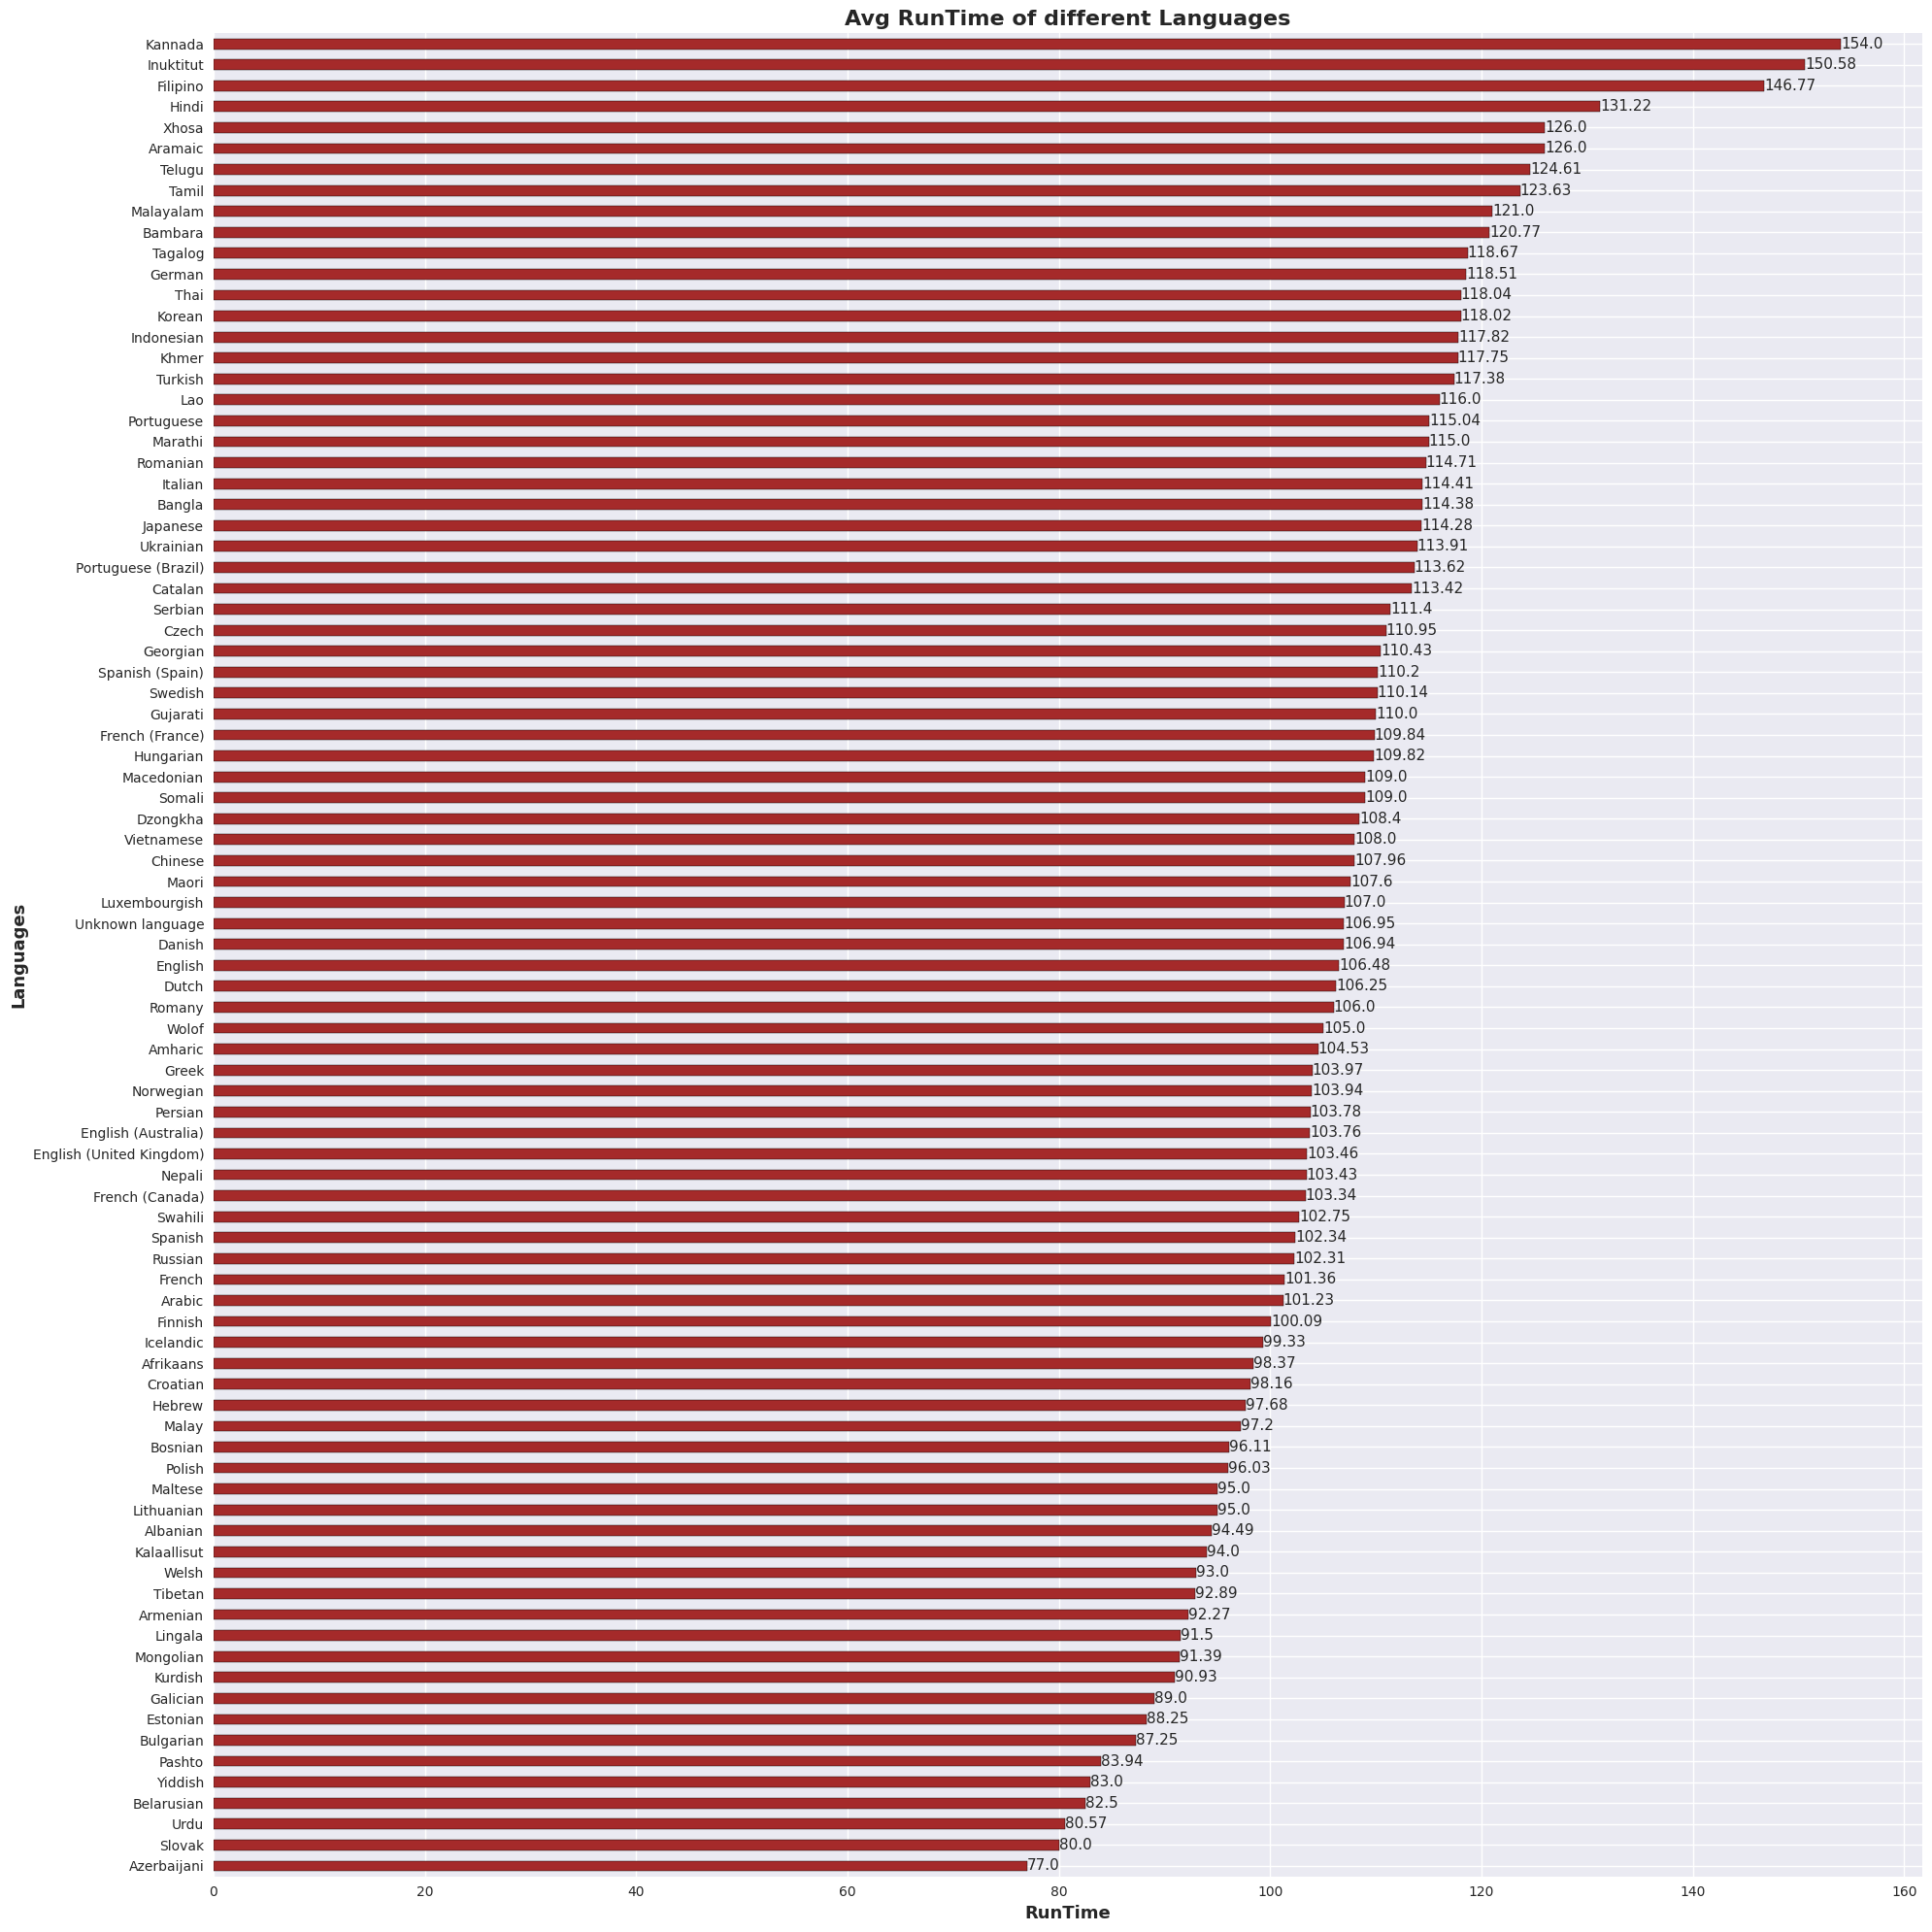

In [39]:
# grouping original language by runtime and rounding off the values by 2 

data_grouped  = merged_train_df_copy.groupby('originalLanguage')['runtimeMinutes'].mean().sort_values()
data_grouped_list = [round(x,2) for x in data_grouped.values.tolist()]

# plotting the graph 

plt.figure(figsize=(20,20))
horizonatal_barplot = data_grouped.plot(kind='barh', color='brown', edgecolor='black')
plt.title('Avg RunTime of different Languages', fontweight='bold', fontsize=16)
plt.xlabel('RunTime', fontweight='bold', fontsize=13)
plt.ylabel('Languages', fontweight='bold', fontsize=13)

for indx,val in enumerate(data_grouped_list):
    horizonatal_barplot.text(val, indx, str(val), ha='left', va='center', fontsize=11)
    
plt.tight_layout();

## Insights

#### Interesting thing to note here that the popular languages do not have the highest audience score. Highest score is occupied by Estonian and Kannada which are not even among the 20 most popular languages. Similary, movies that have the highest runtimes are Kannada, Inuktiut and Flippino which are not the popular languages. 

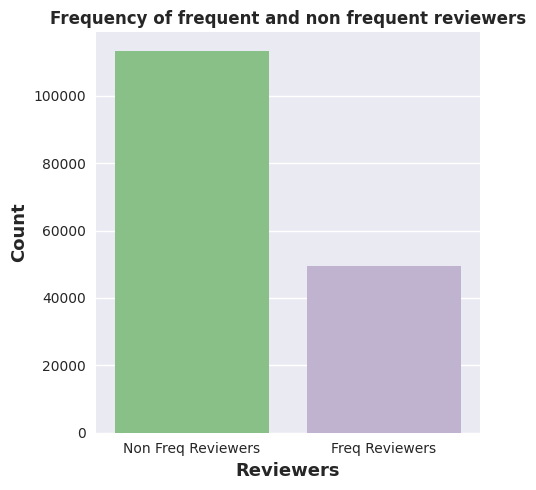

In [40]:
#plotting the count frequent reviewers

plt.figure(figsize=(5,5))
sns.countplot(merged_train_df_copy, x=merged_train_df_copy['isFrequentReviewer_True'], palette='Accent')
plt.title('Frequency of frequent and non frequent reviewers', fontweight='bold', fontsize=12)
plt.xlabel('Reviewers', fontweight='bold', fontsize=13)
plt.ylabel('Count', fontweight='bold', fontsize=13)
plt.xticks([0,1], ['Non Freq Reviewers', 'Freq Reviewers'])
plt.tight_layout();

## Insights

#### The proportion of Non- freq reviewers is much higher than the freq reviewers by almost twice.

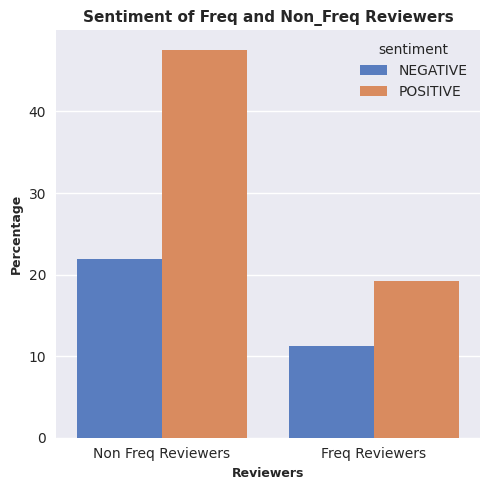

In [41]:
# filtering the dataset by positive and negative sentiment

pos_sentiment = merged_train_df_copy[merged_train_df_copy['sentiment'] == 'POSITIVE']
neg_sentiment = merged_train_df_copy[merged_train_df_copy['sentiment'] == 'NEGATIVE']


# concatenating the two filtered datasets and calculating frequent reviewer percenatge for each sentiment

data_concat = pd.concat([pos_sentiment, neg_sentiment])
data_percentage = ((data_concat.groupby(['isFrequentReviewer_True', 'sentiment'])['sentiment'].count()/ len(data_concat))*100).reset_index(name='percenatge')

# plotting the graph

plt.figure(figsize=(5,5))
sns.barplot(data_percentage, x='isFrequentReviewer_True', y='percenatge', hue='sentiment', palette='muted')
plt.title('Sentiment of Freq and Non_Freq Reviewers', fontweight='bold', fontsize=11)
plt.xlabel('Reviewers', fontweight='bold', fontsize=9)
plt.ylabel('Percentage', fontweight='bold', fontsize=9)
plt.xticks([0,1], ['Non Freq Reviewers', 'Freq Reviewers'])
plt.tight_layout();

## Insights

#### The difference in the positive sentiment of freq and non-freq reviewers is lot more than difference in the negative sentiment. It means that non-frequent reviewers are likely to have negative sentiment.

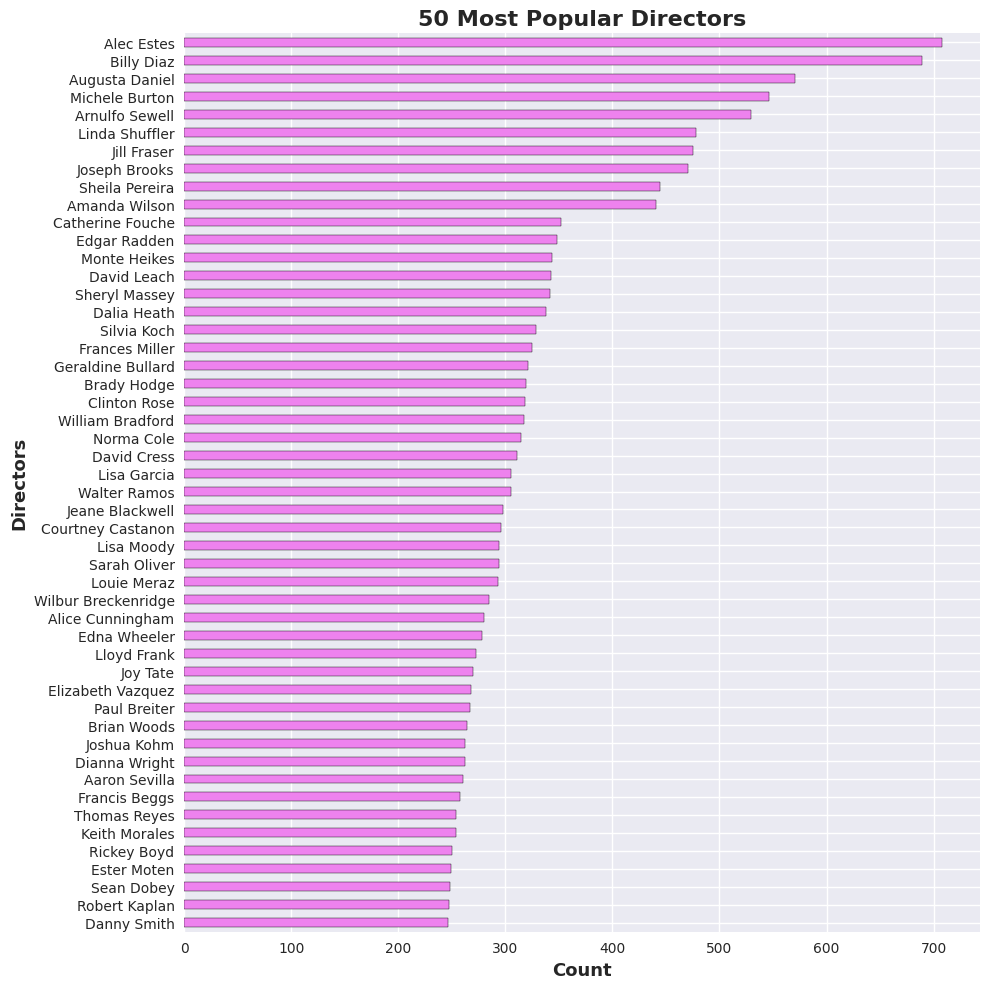

In [42]:
# finding popular directors

data = merged_train_df_copy['director'].value_counts().sort_values(ascending=False).head(50)


# plotting the graph

plt.figure(figsize=(10,10))
plot = data.plot(kind='barh', color='violet', edgecolor='black')
plot.invert_yaxis()
plt.title('50 Most Popular Directors', fontweight='bold', fontsize=16)
plt.xlabel('Count', fontweight='bold', fontsize=13)
plt.ylabel('Directors', fontweight='bold', fontsize=13)
plt.tight_layout();

<Figure size 3000x1500 with 0 Axes>

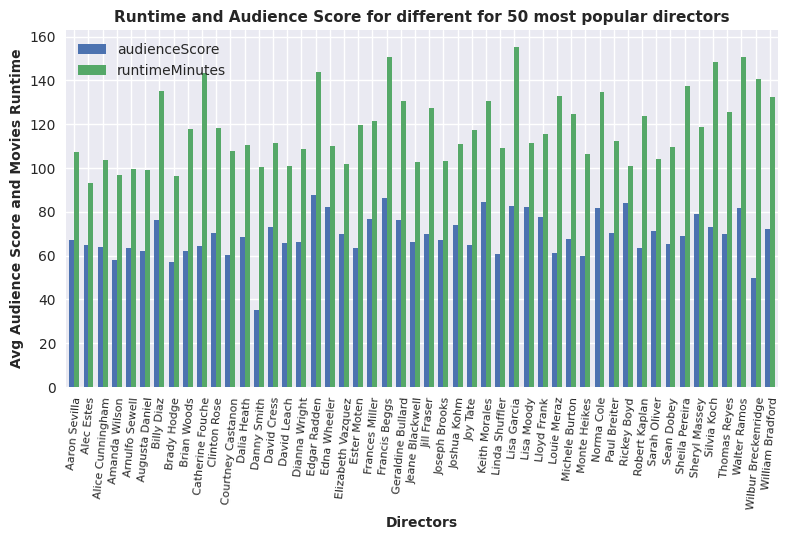

In [43]:
# grouping by audience score to calculate audience score of 50 most popular directors

directors = merged_train_df_copy.groupby('director')['audienceScore'].mean()
directors_filtered_indx = directors.index.isin(merged_train_df_copy['director'].value_counts().sort_values(ascending=False).head(50).index)
directors_filtered_1= directors[directors_filtered_indx]

# grouping by runtime  to calculate runtime of movies for 50 most popular directors

directors = merged_train_df_copy.groupby('director')['runtimeMinutes'].mean()
directors_filtered_indx = directors.index.isin(merged_train_df_copy['director'].value_counts().sort_values(ascending=False).head(50).index)
directors_filtered_2 = directors[directors_filtered_indx]

data= pd.concat([directors_filtered_1, directors_filtered_2], axis=1).reset_index()

# plotting the graph

plt.figure(figsize=(30,15))
data.plot(x='director', kind='bar', width=0.7)
plt.title('Runtime and Audience Score for different for 50 most popular directors', fontweight='bold', fontsize=11)
plt.xlabel('Directors', fontweight='bold',fontsize=10)
plt.ylabel('Avg Audience Score and Movies Runtime', fontweight='bold', fontsize=10)
plt.xticks(fontsize=8, rotation=85)
plt.tight_layout();

## Insights

#### The movies of Lisa Moody have the highest runtime while the movies of Edgar Radden receive the higest audience score.

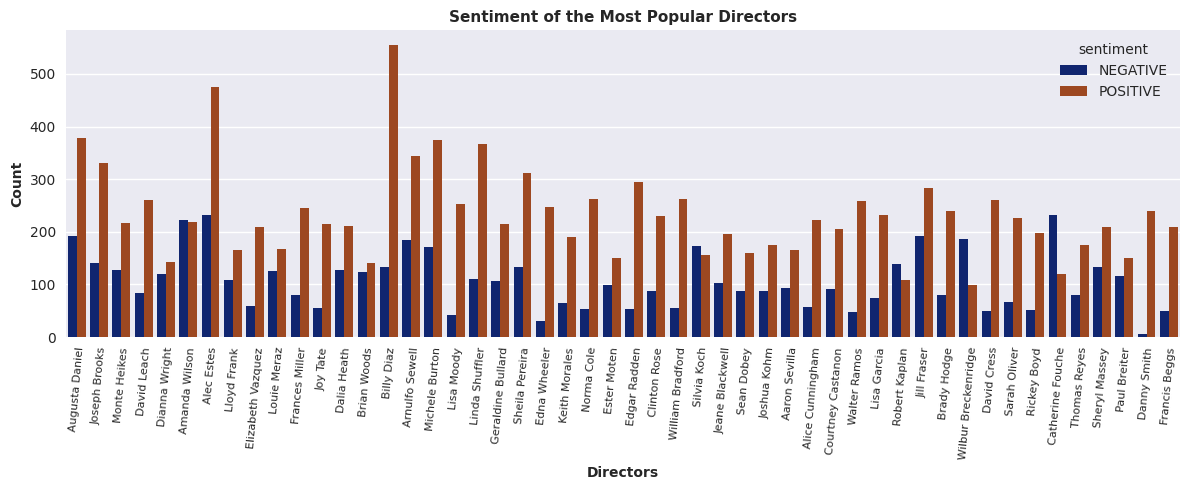

In [44]:
# filtering the dataset

dirs = merged_train_df_copy['director'].value_counts().sort_values(ascending=False).head(50).index
filtered_data = merged_train_df_copy[merged_train_df_copy['director'].isin(dirs)]

# plotting the graph

plt.figure(figsize=(12,5))
sns.countplot(filtered_data, x='director', hue='sentiment', palette='dark')
plt.title('Sentiment of the Most Popular Directors', fontweight='bold', fontsize=11)
plt.xlabel('Directors', fontweight='bold',fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.xticks(fontsize=8, rotation=85)
plt.tight_layout();

## Insights

#### It can be seen from the graph that sentiment of movies made by the popular directors is usually positive. With Billy Diaz receiving the highest positve sentiment and Catherine Fouche receiving the higest negative sentiment.


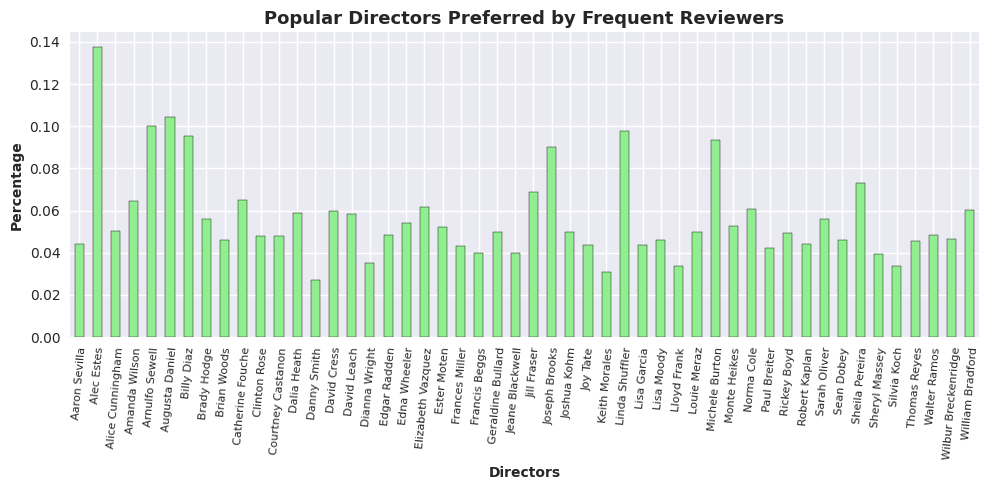

In [45]:
# finding among the popular directors which directors are preferred

dirs_indx = merged_train_df_copy['director'].value_counts().sort_values(ascending=False).head(50).index
filtered_data = merged_train_df_copy[(merged_train_df_copy['director'].isin(dirs_indx)) & merged_train_df_copy['isFrequentReviewer_True'] == 1 ]
data = (filtered_data.groupby('director')['isFrequentReviewer_True'].count() / len(merged_train_df_copy))*100

# plotting the graph

plt.figure(figsize=(10,5))
data.plot(kind='bar', color='lightgreen', edgecolor='black');
plt.title('Popular Directors Preferred by Frequent Reviewers', fontweight='bold', fontsize=13)
plt.xlabel('Directors', fontweight='bold', fontsize=10)
plt.ylabel('Percentage', fontweight='bold', fontsize=10)
plt.xticks(fontsize=8,rotation=85)
plt.tight_layout();

## Insights

#### It can be seen from the graph Alec Estes, Augusta Daniel and Linda Shuffler are the top 3 preferred choices of frequent reviewers.

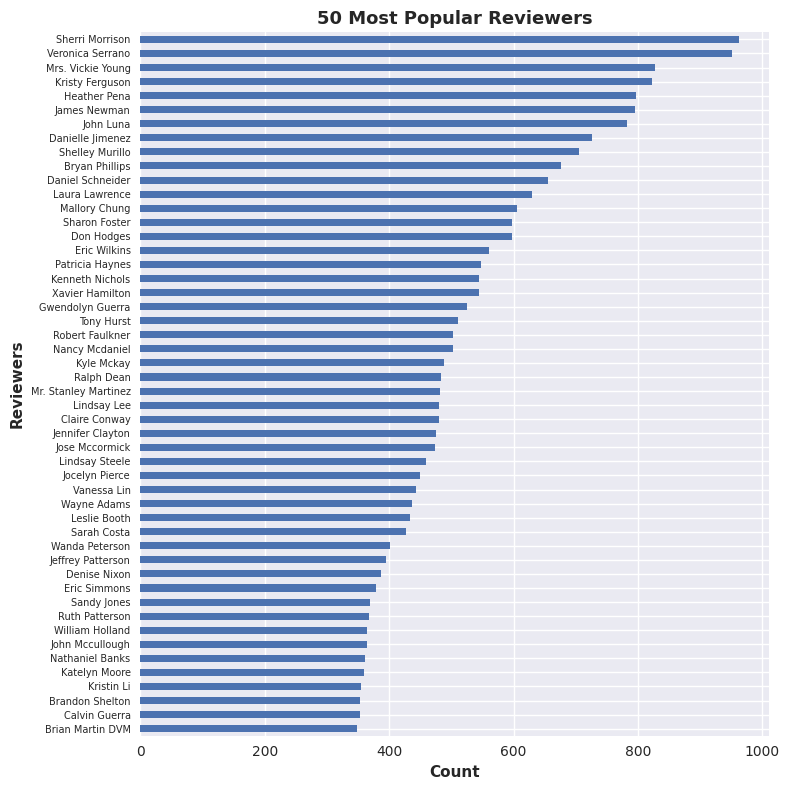

In [46]:
#calculating the 50 most popular reviewers
popular_reviewers = merged_train_df_copy['reviewerName'].value_counts().sort_values(ascending=False).head(50)

#plotting the graph
plt.figure(figsize=(8,8))
plot = popular_reviewers.plot(kind='barh')
plot.invert_yaxis()
plt.title('50 Most Popular Reviewers', fontweight='bold', fontsize=13)
plt.xlabel('Count',fontweight='bold', fontsize=11)
plt.ylabel('Reviewers', fontweight='bold', fontsize=11)
plt.yticks(fontsize=7)
plt.tight_layout();

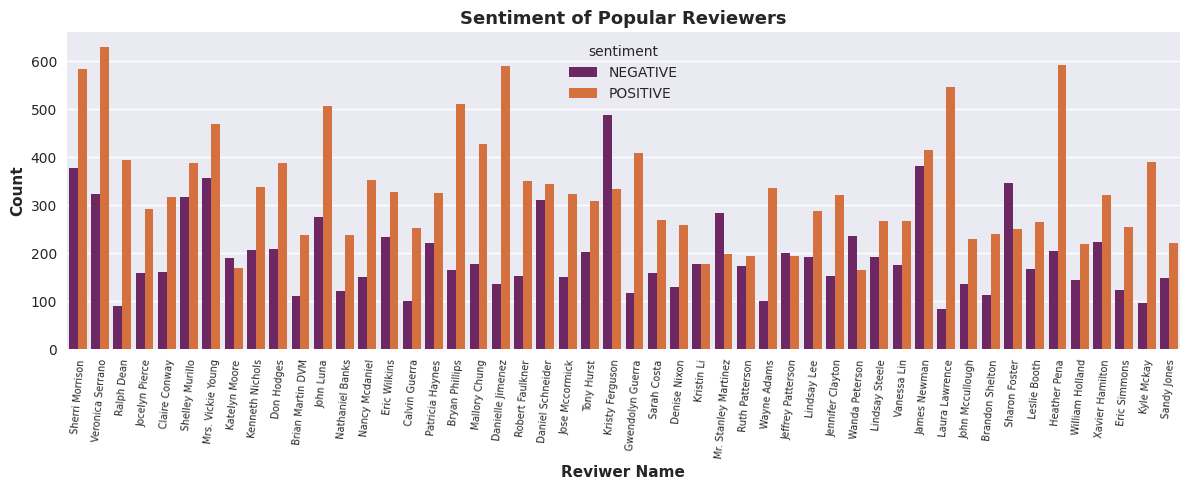

In [47]:
#filtering the data by the popular directors
filtered_by_reviewers = merged_train_df_copy[merged_train_df_copy['reviewerName'].isin(popular_reviewers.index)]

#plotting the sentiment of the popular reviewers

plt.figure(figsize=(12,5))
sns.countplot(data=filtered_by_reviewers, x='reviewerName', hue='sentiment', palette='inferno')
plt.title('Sentiment of Popular Reviewers', fontweight='bold', fontsize=13)
plt.xlabel('Reviwer Name',fontweight='bold', fontsize=11)
plt.ylabel('Count', fontweight='bold', fontsize=11)
plt.xticks(rotation=85, fontsize=7)
plt.tight_layout();

## Insights

#### It can be seen from the graph that popular reviewers are generally going to have positive sentiment except for few reviewers like Kristy Ferguson, Sharon Foster, Katelyn Morre where sentiment can be negative.

In [48]:
#list of Frequent Reviewers among the popular reviewers

pd.DataFrame(filtered_by_reviewers[filtered_by_reviewers['isFrequentReviewer_True'] == 1]['reviewerName'].unique(), columns=['Frequent Reviewers'])

Frequent Reviewers
0   Mrs. Vickie Young
1          Don Hodges
2    Brian Martin DVM
3           John Luna
4     Nathaniel Banks
5       Calvin Guerra
6      Bryan Phillips
7     Robert Faulkner
8    Daniel Schneider
9         Lindsay Lee
10   Jennifer Clayton
11     Wanda Peterson
12    John Mccullough
13       Leslie Booth
14    William Holland
15         Tony Hurst
16    Sherri Morrison
17      Sharon Foster
18    Xavier Hamilton
19        Vanessa Lin
20       Denise Nixon

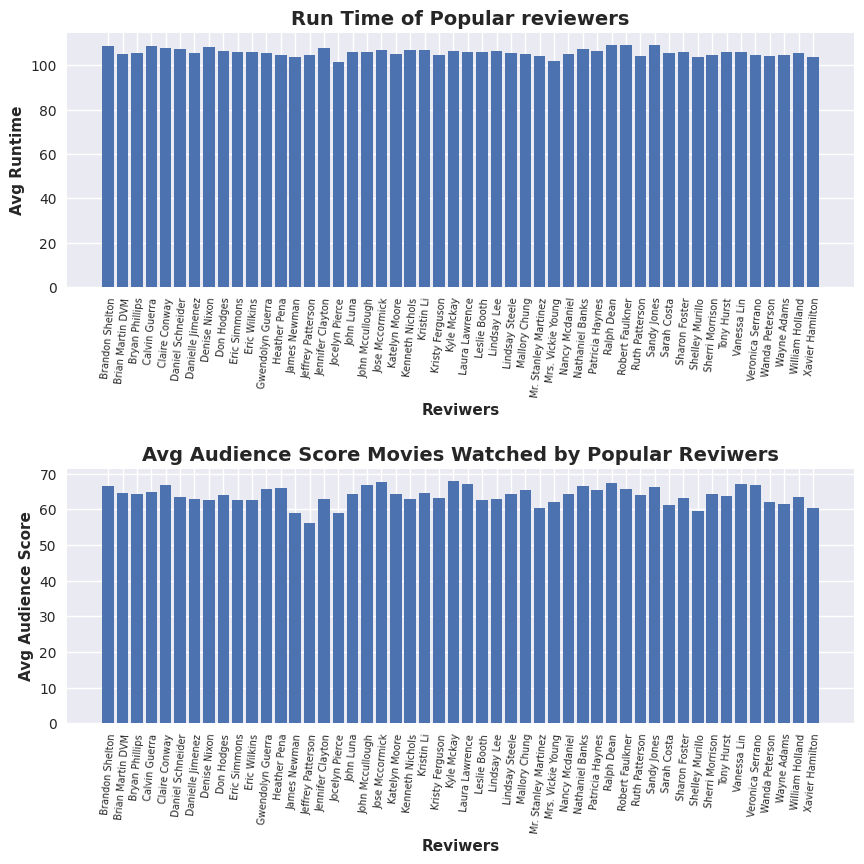

In [49]:
# Runtime and Audience Score of Popular Reviewer

avg_run_of_reviewers = filtered_by_reviewers.groupby('reviewerName')['runtimeMinutes'].mean()
audienceScore_reviewers = filtered_by_reviewers.groupby('reviewerName')['audienceScore'].mean()

data_concat = pd.concat([avg_run_of_reviewers, audienceScore_reviewers], axis = 1).reset_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,9))

ax[0].bar(data_concat['reviewerName'], data_concat['runtimeMinutes'])
ax[0].set_title('Run Time of Popular reviewers', fontweight='bold', fontsize=14)
ax[0].set_xlabel('Reviwers', fontweight='bold', fontsize=11)
ax[0].set_ylabel('Avg Runtime', fontweight='bold', fontsize=11)
ax[0].tick_params(axis='x', rotation=85, labelsize=7)

plot_2 = ax[1].bar(data_concat['reviewerName'], data_concat['audienceScore'])
ax[1].set_title('Avg Audience Score Movies Watched by Popular Reviwers',fontweight='bold', fontsize=14)
ax[1].set_xlabel('Reviwers', fontweight='bold', fontsize=11)
ax[1].set_ylabel('Avg Audience Score', fontweight='bold', fontsize=11)
ax[1].tick_params(axis='x', rotation=85, labelsize=7)

plt.tight_layout(pad=2);

## Insights

#### Popular reviewers are going movies with runtime around 90-100 with an audience score 60-70

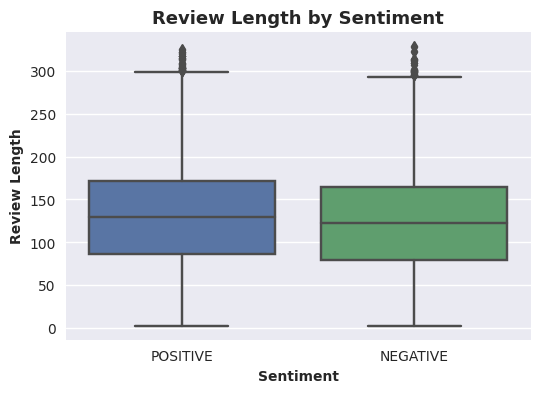

In [50]:
#plotting the boxplot for sentiment and review length

plt.figure(figsize=(6, 4))
sns.boxplot(x='sentiment', y='reviewLength', data=merged_train_df_copy)
plt.title('Review Length by Sentiment',fontweight='bold', fontsize=13)
plt.xlabel('Sentiment', fontweight='bold', fontsize=10)
plt.ylabel('Review Length',fontweight='bold', fontsize=10)
plt.show()

## Insight

#### It can be seen from the boxplot review length does not seem to have a great impact of sentiment. Moreover, there are outliers present in the review length of positive and negative sentiment.

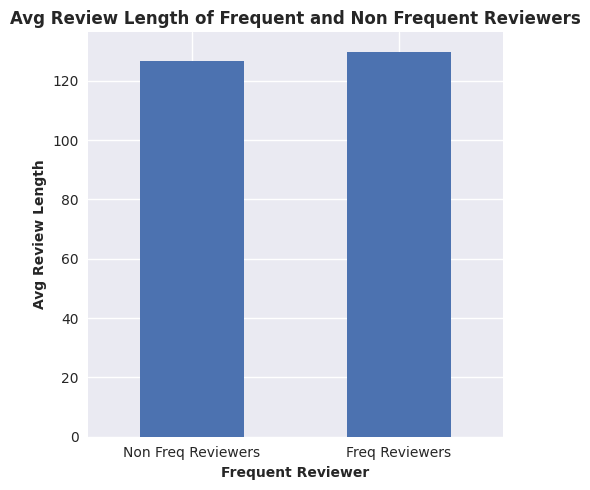

In [51]:
data = merged_train_df_copy.groupby('isFrequentReviewer_True')['reviewLength'].mean()

plt.figure(figsize=(5,5))
data.plot(kind='bar')
plt.title('Avg Review Length of Frequent and Non Frequent Reviewers', fontsize=12,fontweight='bold')
plt.xlabel('Frequent Reviewer', fontsize=10, fontweight='bold')
plt.ylabel('Avg Review Length', fontsize=10, fontweight='bold')
plt.xticks([0,1], ['Non Freq Reviewers', 'Freq Reviewers'], rotation=360)
plt.tight_layout();

## Insight

#### It can seen from the graph that frequency of reviewers does not impact the length of the review.

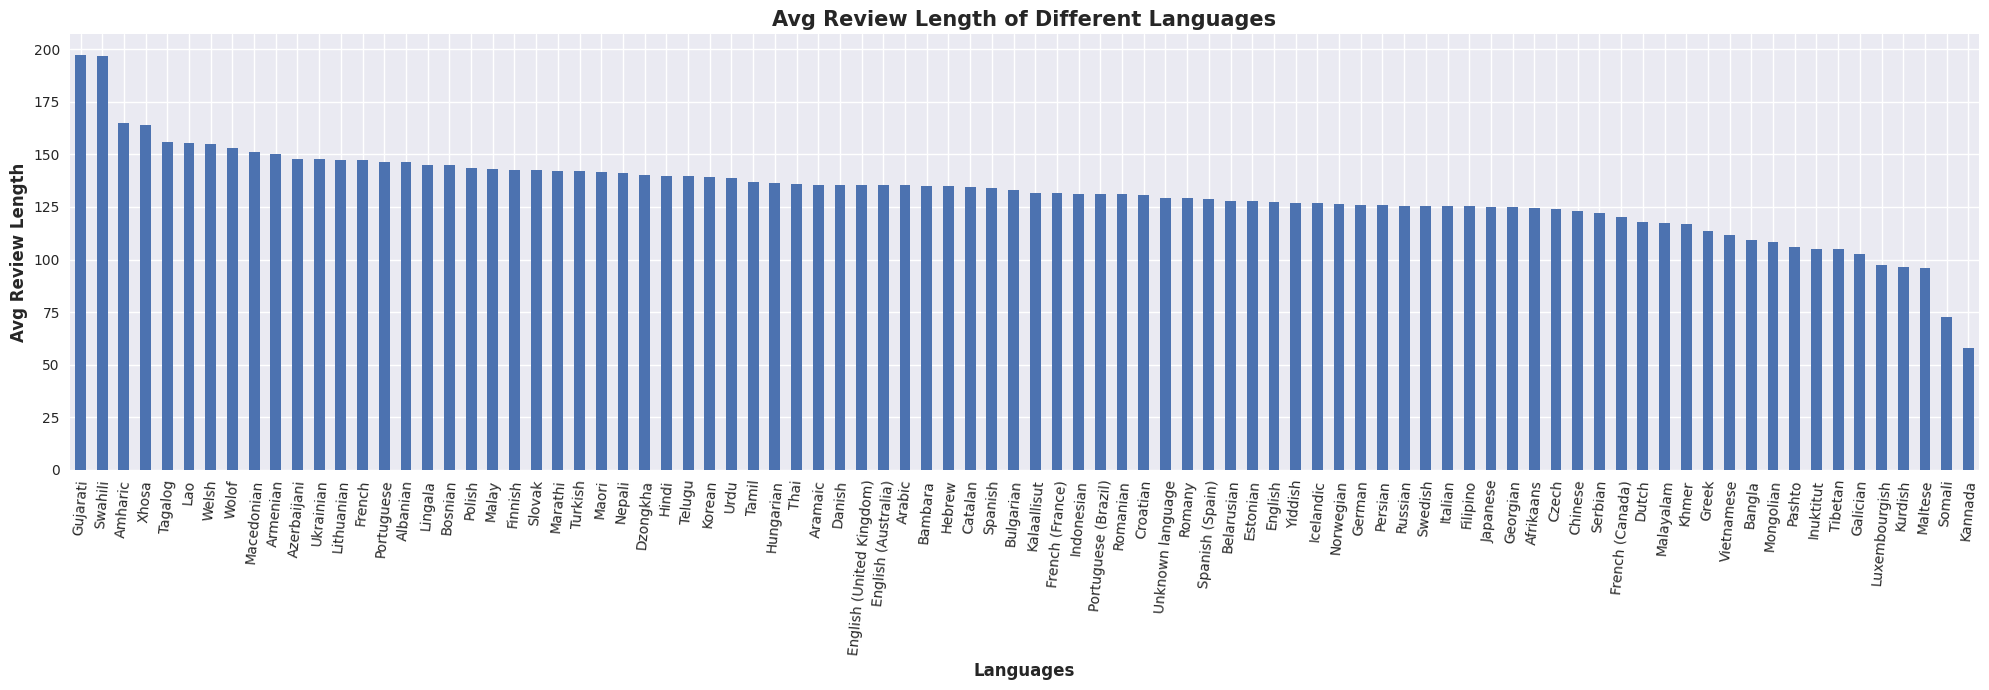

In [52]:
data = merged_train_df_copy.groupby('originalLanguage')['reviewLength'].mean().sort_values(ascending=False)

plt.figure(figsize=(20,7))
data.plot(kind='bar')
plt.title('Avg Review Length of Different Languages', fontsize=15,fontweight='bold')
plt.xlabel('Languages', fontsize=12, fontweight='bold')
plt.ylabel('Avg Review Length', fontsize=12, fontweight='bold')
plt.xticks(rotation=85)
plt.tight_layout();

## Insights

#### It can seen from the graph that Gujarti and Swahilli have longest length in terms of reviews. Moreover, English the most popular language does not have much lengthy reviews.



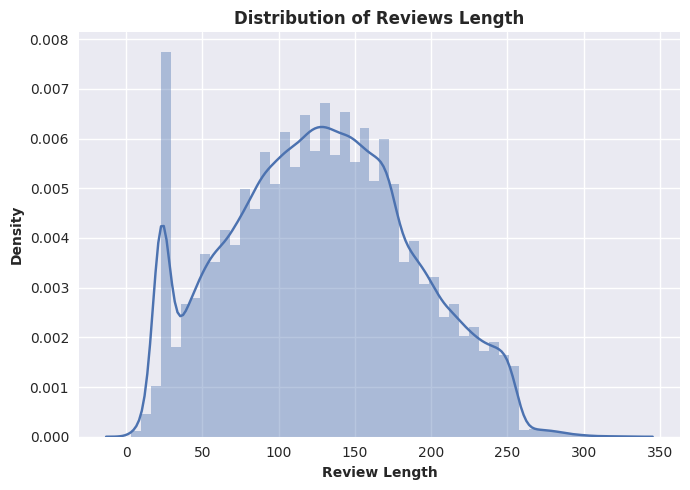

In [53]:
plt.figure(figsize=(7,5))
sns.distplot(merged_train_df_copy['reviewLength'])
plt.title('Distribution of Reviews Length', fontweight='bold', fontsize=12)
plt.xlabel('Review Length', fontweight='bold', fontsize=10)
plt.ylabel('Density', fontweight='bold', fontsize=10)
plt.tight_layout();

## Insights

#### Most of reviews have length around 120-130 words.

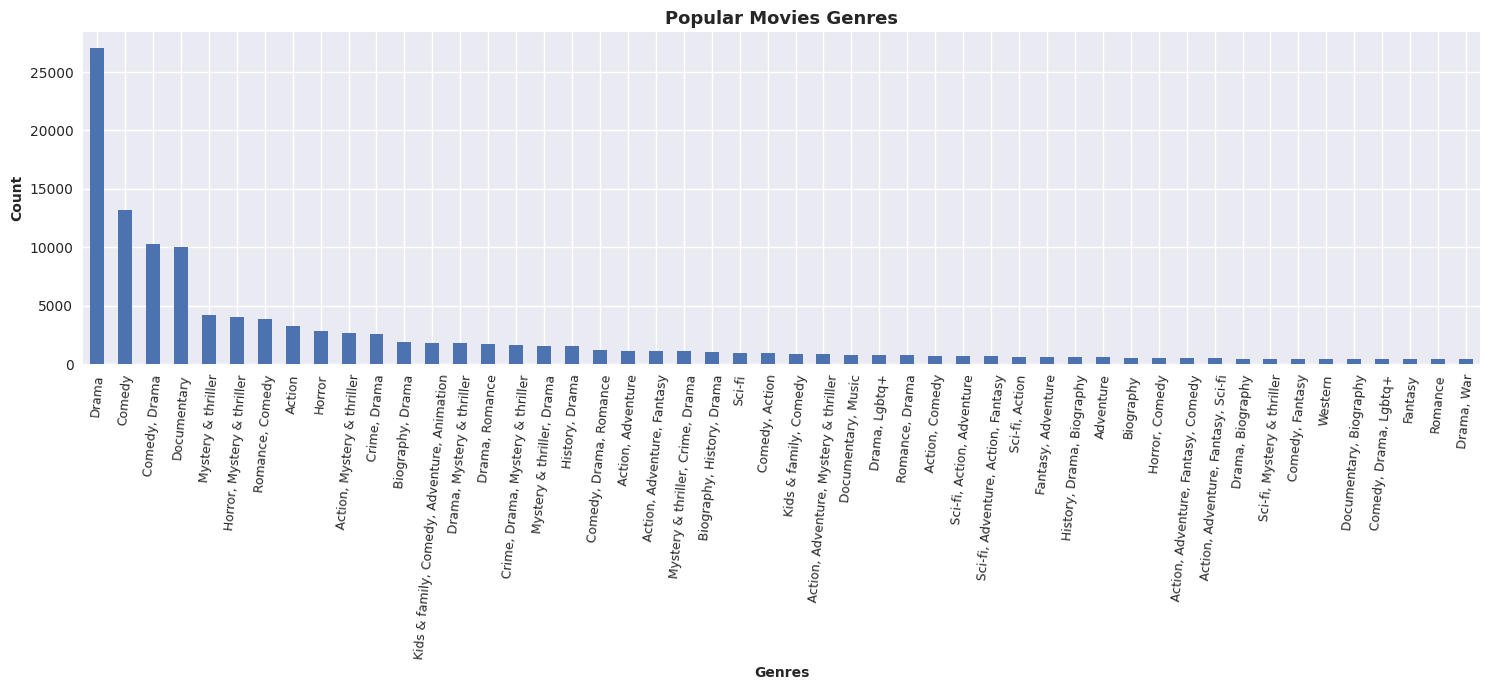

In [54]:
plt.figure(figsize=(15,7))
popular_genres = merged_train_df_copy['genre'].value_counts().head(50)
popular_genres.plot(kind='bar')
plt.title('Popular Movies Genres', fontweight='bold', fontsize=13)
plt.xlabel('Genres', fontweight='bold', fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.xticks(rotation=85, fontsize=9)
plt.tight_layout();

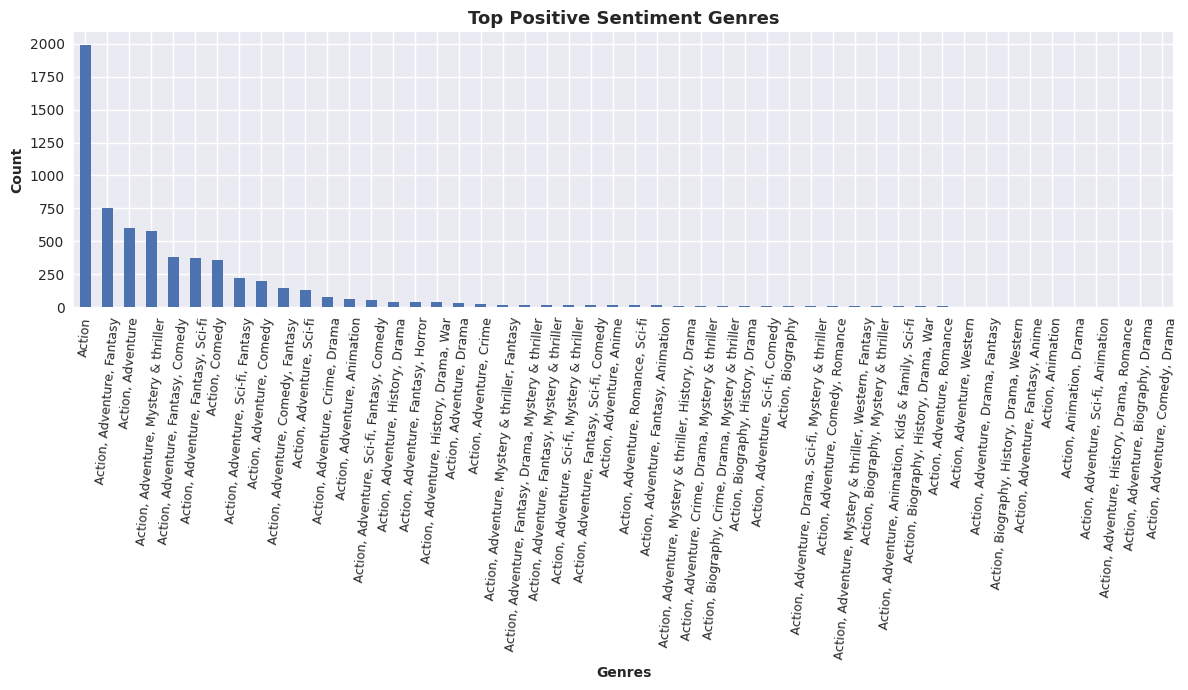

In [55]:
filtered_by_pos_sentiment = merged_train_df_copy[merged_train_df_copy['sentiment'] == 'POSITIVE']

plt.figure(figsize=(12,7))
data = filtered_by_pos_sentiment.groupby('genre')['sentiment'].count().head(50).sort_values(ascending= False)
data.plot(kind='bar')
plt.title('Top Positive Sentiment Genres', fontweight='bold', fontsize=13)
plt.xlabel('Genres', fontweight='bold', fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.xticks(rotation=85, fontsize=9)
plt.tight_layout();

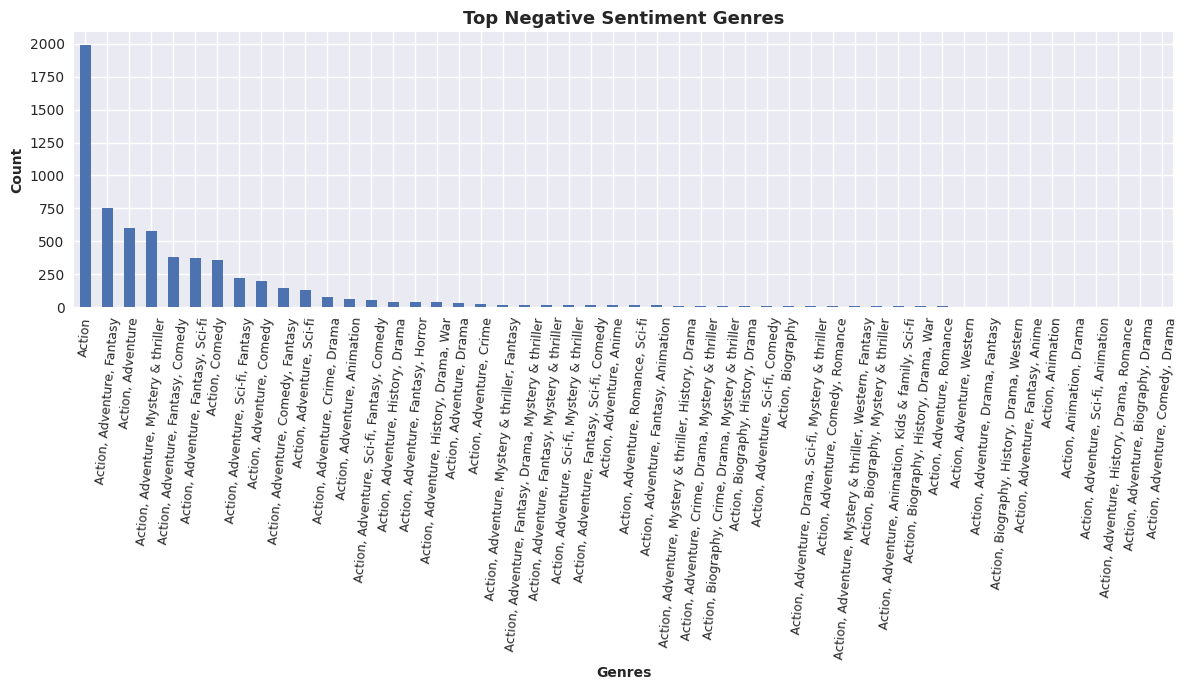

In [56]:
filtered_by_neg_sentiment = merged_train_df_copy[merged_train_df_copy['sentiment'] == 'NEGATIVE']

plt.figure(figsize=(12,7))
data = filtered_by_pos_sentiment.groupby('genre')['sentiment'].count().head(50).sort_values(ascending= False)
data.plot(kind='bar')
plt.title('Top Negative Sentiment Genres', fontweight='bold', fontsize=13)
plt.xlabel('Genres', fontweight='bold', fontsize=10)
plt.ylabel('Count', fontweight='bold', fontsize=10)
plt.xticks(rotation=85, fontsize=9)
plt.tight_layout();

## Insights

#### From the above graphs, Action is the top genre for positive and negative sentiment and it is 8th most popular genre. On the other hand, Drama(solo) is the popular genre overall but it is not the top genre for classifying positive and negative sentiment.


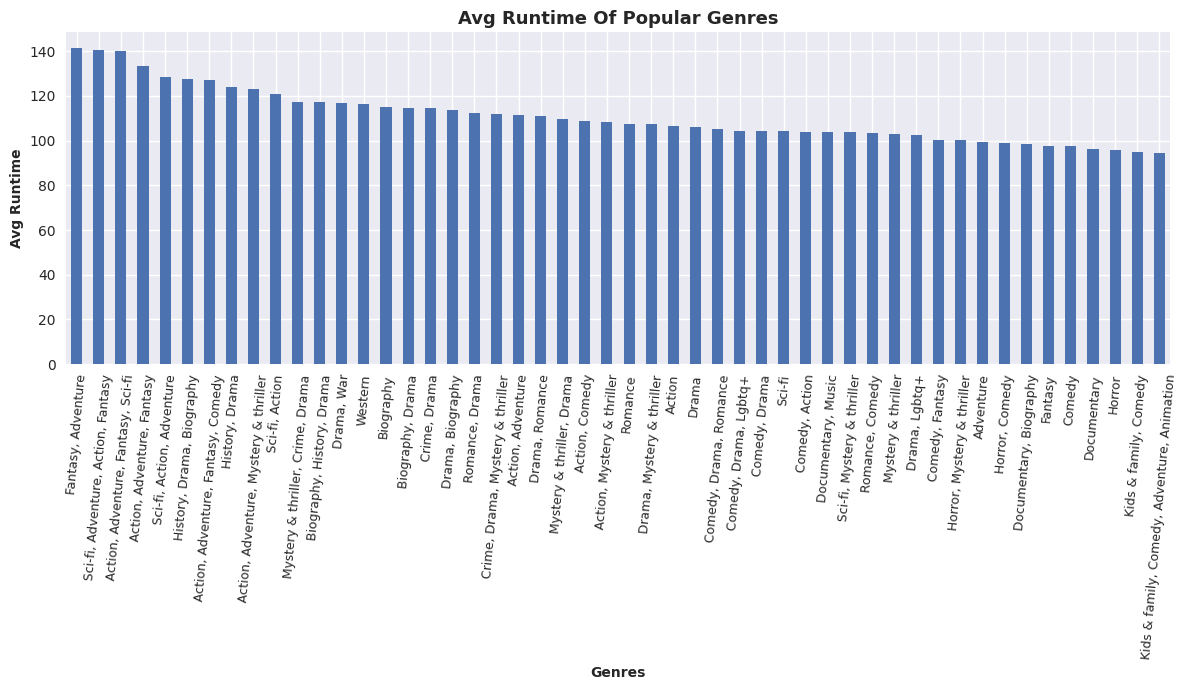

In [57]:
filterd_by_popular_genre = merged_train_df_copy[merged_train_df_copy['genre'].isin(popular_genres.index)]
data_genre_runtime = filterd_by_popular_genre.groupby('genre')['runtimeMinutes'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,7))
data_genre_runtime.plot(kind='bar')
plt.title('Avg Runtime Of Popular Genres', fontweight='bold', fontsize=13)
plt.xlabel('Genres', fontweight='bold', fontsize=10)
plt.ylabel('Avg Runtime', fontweight='bold', fontsize=10)
plt.xticks(rotation=85, fontsize=9)
plt.tight_layout();

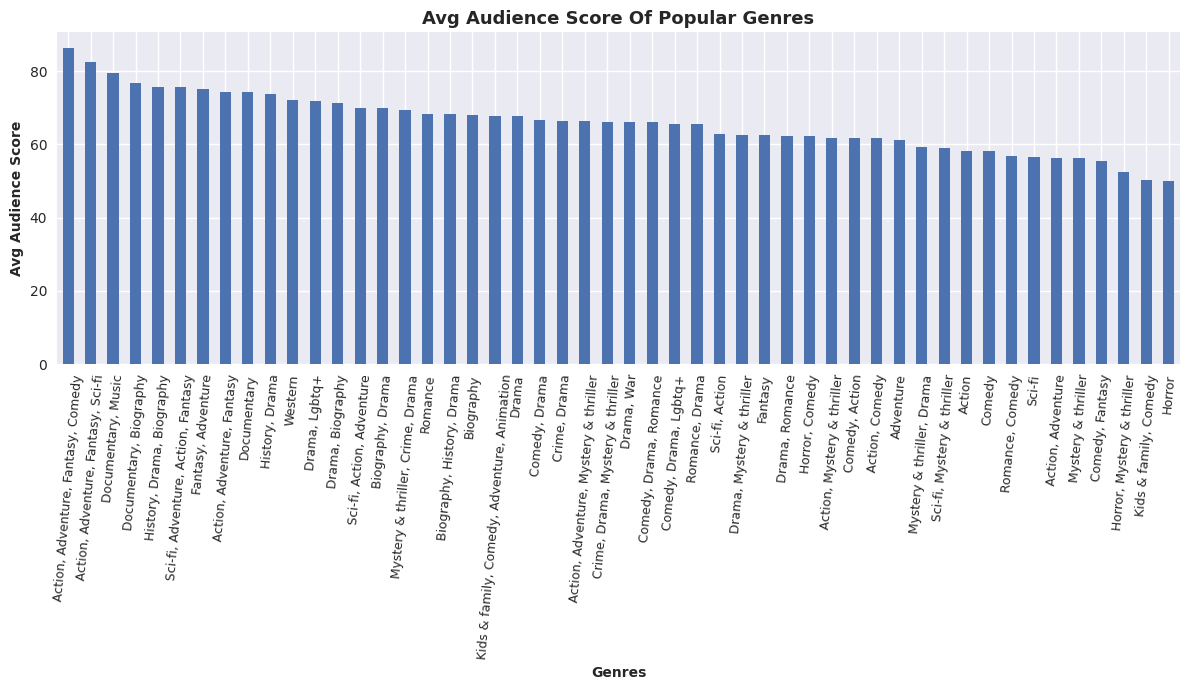

In [58]:
data_genre_audience_score = filterd_by_popular_genre.groupby('genre')['audienceScore'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,7))
data_genre_audience_score.plot(kind='bar')
plt.title('Avg Audience Score Of Popular Genres', fontweight='bold', fontsize=13)
plt.xlabel('Genres', fontweight='bold', fontsize=10)
plt.ylabel('Avg Audience Score', fontweight='bold', fontsize=10)
plt.xticks(rotation=85, fontsize=9)
plt.tight_layout();

# **Preprocessing**

## Spliting the label and the features

In [59]:
# dropping the label column: sentiment

X = merged_train_df.drop(columns=['sentiment'])
print('Shape of X: ',X.shape)

Shape of X:  (162758, 9)


In [60]:
# only keeping the label column: sentiment

y = merged_train_df['sentiment']
print('Shape of y: ',y.shape)

Shape of y:  (162758,)


## Perfroming the data into training and testing dataset

In [61]:
# splitting the training dataset and keeping 20 percent of values for testing


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, shuffle= True,
                                                    random_state=45)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (130206, 9)
Shape of X_test: (32552, 9)
Shape of y_train: (130206,)
Shape of y_test: (32552,)


In [62]:
X_train.head()

movieid  audienceScore  runtimeMinutes  \
101890        james_t._kirk_velvet_phantom           77.0      106.000000   
118876           bruce_wayne_t-800_gandalf           81.0      117.000000   
139025  supreme_katniss_everdeen_fantastic           50.0      107.000000   
21538              illusion_luke_skywalker           59.0       62.333333   
104632              majestic_witch_destiny           64.0       99.000000   

           originalLanguage               genre        director  \
101890  English (Australia)     Romance, Comedy    Donald Canez   
118876              English               Drama  Margaret Klare   
139025              English  Mystery & thriller    Jamie Delosh   
21538               English               Drama   Tammy Mullins   
104632              English               Drama  Dorothy Zamora   

                reviewerName  isFrequentReviewer  \
101890             Sara Todd               False   
118876  Mr. Stanley Martinez               False   
139025       Grace Alexander               False   
21538          Justin Willis               False   
104632        Thomas Stewart                True   

                                               reviewText  
101890  Ali's Wedding by contrast gets its big laughs ...  
118876  The true story is fascinating, groundbreaking ...  
139025  Silicon Valley story of good versus evil-sort of.  
21538   This scenically spectacular, pleasing if somet...  
104632  It sheds much needed light on a mostly forgott...

In [63]:
y_train.head()

101890    POSITIVE
118876    NEGATIVE
139025    NEGATIVE
21538     POSITIVE
104632    POSITIVE
Name: sentiment, dtype: object

## Dropping Columns from X_train

In [64]:
X_train['originalLanguage'].value_counts(normalize=True).head().sort_values(ascending=False)

# we will drop the this column because Englsih (the most popular language) has very high frequency of 80 percent
# which  might create bias while predicting. The second most popular langauge only has a frequency of 1%. 

originalLanguage
English                     0.877904
French (France)             0.016432
English (United Kingdom)    0.014418
French (Canada)             0.011471
Chinese                     0.010453
Name: proportion, dtype: float64

In [65]:
X_train.drop(columns = ['movieid','originalLanguage', 'director', 'reviewerName', 'genre'],
            inplace = True)

X_test.drop(columns = ['movieid','originalLanguage', 'director', 'reviewerName', 'genre'],
            inplace = True)

In [66]:
X_train.head()

audienceScore  runtimeMinutes  isFrequentReviewer  \
101890           77.0      106.000000               False   
118876           81.0      117.000000               False   
139025           50.0      107.000000               False   
21538            59.0       62.333333               False   
104632           64.0       99.000000                True   

                                               reviewText  
101890  Ali's Wedding by contrast gets its big laughs ...  
118876  The true story is fascinating, groundbreaking ...  
139025  Silicon Valley story of good versus evil-sort of.  
21538   This scenically spectacular, pleasing if somet...  
104632  It sheds much needed light on a mostly forgott...

## Imputation and Transformation

In [67]:
#checking for null values in taining dataset

(X_train.isnull().sum()/ X_train.shape[0])*100

audienceScore         1.743391
runtimeMinutes        0.453128
isFrequentReviewer    0.000000
reviewText            3.952199
dtype: float64

In [68]:
# defining a custom transformer into the output into a data frame

class ToDataFrame(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X, columns= ['audienceScore','runtimeMinutes','isFrequentReviewer','reviewText'])
        return X

In [69]:
# imputing the missing values except for reviewText

ct_imputer = ColumnTransformer([
    ('num_imputer', SimpleImputer(), ['audienceScore', 'runtimeMinutes']),
],remainder='passthrough', verbose_feature_names_out = False)
# ------------------------------------------------------------------------------------------------------------------------------------------  

# transforming the columns except for reviewText
ct_tf = ColumnTransformer([
    ('scaler', StandardScaler(), ['audienceScore', 'runtimeMinutes']),
    ('ohe_1', OneHotEncoder(drop='first', sparse=False), ['isFrequentReviewer']),                                                                
], verbose_feature_names_out=False)
# ------------------------------------------------------------------------------------------------------------------------------------------  

# creating a pipeline for all the columns except for reviewText

pipe_1 = Pipeline([
    ('imputer', ct_imputer),
    ('to_df', ToDataFrame()),
    ('tf', ct_tf)
])

X_train_tf = pipe_1.fit_transform(X_train)
X_test_tf = pipe_1.transform(X_test)

In [70]:
# imputing the missing values in the reviewText column 
imputer = SimpleImputer(strategy='most_frequent')
reviewText_train = imputer.fit_transform(X_train[['reviewText']]).flatten()
reviewText_test= imputer.transform(X_test[['reviewText']]).flatten()

# vectorizing the reviewText column using Tfidf vectorizer
vec = TfidfVectorizer(lowercase=True, stop_words=list(ENGLISH_STOP_WORDS))
reviewText_train_tf = vec.fit_transform(reviewText_train)
reviewText_test_tf = vec.transform(reviewText_test)

In [71]:
# concatenating the final output and getting a sparse matrix for training and testing data

X_train_sparse = sparse.hstack([X_train_tf, reviewText_train_tf])
X_test_sparse = sparse.hstack([X_test_tf, reviewText_test_tf])

In [72]:
print('Shape of X_train_sparse:', X_train_sparse.shape)
print('Shape of X_test_sparse:', X_test_sparse.shape)

Shape of X_train_sparse: (130206, 59850)
Shape of X_test_sparse: (32552, 59850)


In [73]:
le = LabelEncoder()

y_train_tf = le.fit_transform(y_train)
y_test_tf = le.transform(y_test)

# **Model-1: Logisitc Regression**

In [74]:
# since our dataset is imbalanced we are keeping class weight as balanced to reduce the imbalance

pipe_2 = Pipeline([
    ('lr_clf', LogisticRegression(random_state=45, class_weight='balanced'))
])

pipe_2.fit(X_train_sparse, y_train_tf)  #runtime 8s

Pipeline(steps=[('lr_clf',
                 LogisticRegression(class_weight='balanced', random_state=45))])

In [75]:
print('f1-Score without any hyperparameter tunning:', f1_score(y_test_tf, pipe_2.predict(X_test_sparse), average='micro'))
print('Accuracy-Score without any hyperparameter tunning:', accuracy_score(y_test_tf, pipe_2.predict(X_test_sparse)))
print('Precision-Score without any hyperparameter tunning:', precision_score(y_test_tf, pipe_2.predict(X_test_sparse)))
print('Recall-Score without any hyperparameter tunning:', recall_score(y_test_tf, pipe_2.predict(X_test_sparse)))

f1-Score without any hyperparameter tunning: 0.7944212337183583
Accuracy-Score without any hyperparameter tunning: 0.7944212337183583
Precision-Score without any hyperparameter tunning: 0.8786617174959872
Recall-Score without any hyperparameter tunning: 0.8039008719596145


## Hyperparameter Tunning for Logisitic Regression

In [76]:
# defining a param grid

# param_grid = {'lr_clf__C':[0.001, 0.1, 1, 100, 1000],
#               'lr_clf__max_iter':[10000,30000],
#               'lr_clf__solver':['liblinear', 'lbfgs']}
              

# # using random search CV for finding the best parameters 

# lr_clf_rs = RandomizedSearchCV(pipe_2, param_distributions=param_grid, cv=4, scoring='accuracy', n_jobs=-1, random_state=45)
# lr_clf_rs.fit(X_train_sparse, y_train_tf) #runtime 15 mins

In [77]:
# print('Best params for Logistic Regression model are:',lr_clf_rs.best_params_)

In [78]:
# fitting the best estimator

# lr_best_estimator = lr_clf_rs.best_estimator_
# lr_best_estimator.fit(X_train_sparse, y_train_tf) 

In [79]:
print('Best paramaters of model are: ', {'C': 1, 'max_iter': 30000 , 'sover': 'liblinear'})

Best paramaters of model are:  {'C': 1, 'max_iter': 30000, 'sover': 'liblinear'}


In [80]:
lr_best_estimator = LogisticRegression(random_state=45, class_weight= 'balanced', solver='liblinear',max_iter = 30000, C=1)
lr_best_estimator.fit(X_train_sparse, y_train_tf) 

LogisticRegression(C=1, class_weight='balanced', max_iter=30000,
                   random_state=45, solver='liblinear')

In [81]:
print('f1-Score after hyperparameter tunning:', f1_score(y_test_tf, lr_best_estimator.predict(X_test_sparse), average='micro'))
print('Accuracy-Score after hyperparameter tunning:', accuracy_score(y_test_tf, lr_best_estimator.predict(X_test_sparse)))
print('Precision-Score after hyperparameter tunning:', precision_score(y_test_tf, lr_best_estimator.predict(X_test_sparse)))
print('Recall-Score after hyperparameter tunning:', recall_score(y_test_tf, lr_best_estimator.predict(X_test_sparse)))

f1-Score after hyperparameter tunning: 0.7936839518309168
Accuracy-Score after hyperparameter tunning: 0.7936839518309167
Precision-Score after hyperparameter tunning: 0.8800040334778663
Recall-Score after hyperparameter tunning: 0.8010096374483708


## Confusion Matrix

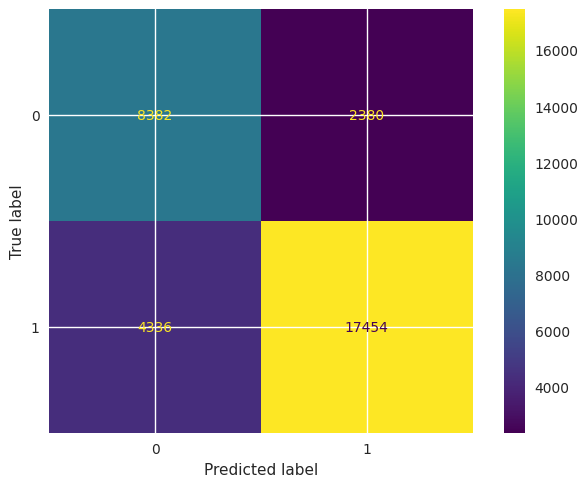

In [82]:
#plotting the confusion matrix

cm = ConfusionMatrixDisplay.from_predictions(y_test_tf, lr_best_estimator.predict(X_test_sparse), cmap='viridis');

In [83]:
false_negatives = cm.confusion_matrix[1][0]
false_positives = cm.confusion_matrix[0][1]
true_negatives = cm.confusion_matrix[0][0]
true_positives = cm.confusion_matrix[1][1]
total = false_negatives + false_positives + true_negatives + true_positives
misclassification_rate = (false_negatives + false_positives)/total
classification_rate = (true_negatives + true_positives)/ total

print('Misclassification rate of the model: ', misclassification_rate)

Misclassification rate of the model:  0.2063160481690833


## Evaluating the Perfromance of the Model

In [84]:
# plotting a learning curve for 5 training sizes with cross validation as 3

train_sizes, train_scores, test_scores = learning_curve(estimator= lr_best_estimator, X = X_train_sparse, y=y_train_tf, 
                                                       scoring='accuracy' ,train_sizes = np.linspace(0.1, 1, 5), cv=3, n_jobs= -1)  

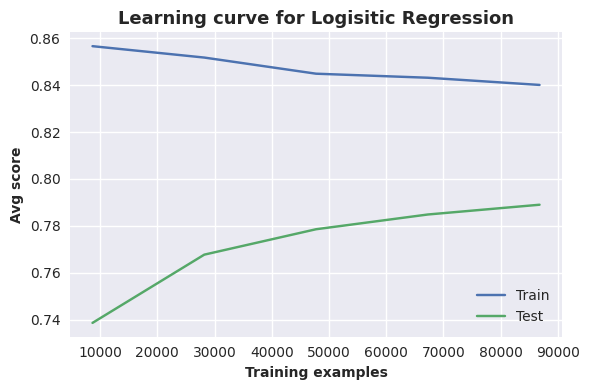

In [85]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, label='Train')
plt.plot(train_sizes, test_mean, label='Test')

plt.title('Learning curve for Logisitic Regression', fontweight='bold', fontsize=13)
plt.xlabel('Training examples', fontweight='bold', fontsize=10)
plt.ylabel('Avg score', fontweight='bold', fontsize=10)
plt.legend(loc='best')

plt.tight_layout();

### Insights
#### 1. When are trainig size is small our model is overfitting since there is high gap in training and testing score.
#### 2. But, as we increase our training size our model starts to performs better and reduces overfitting. This is evident from the curve, for the large  training sizes testing score increases signicantly and our training score also comes down indicating model is not fitting noise.


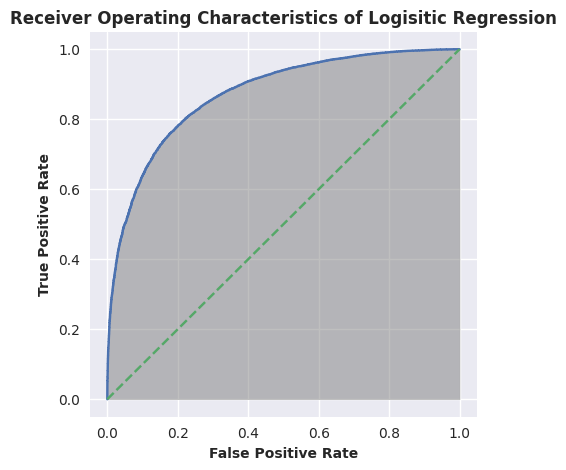

In [86]:
# plotting the roc curve

fpr,tpr, thresh = roc_curve(y_test_tf, lr_best_estimator.predict_proba(X_test_sparse)[:,1])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.title('Receiver Operating Characteristics of Logisitic Regression', fontweight='bold', fontsize=12)
plt.fill_between(fpr, tpr, color='gray', alpha=0.5)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=10)
plt.xlabel('False Positive Rate',fontweight='bold', fontsize=10);

In [87]:
print('ROC AUC of Logisitc Regression: ', roc_auc_score(y_test_tf, lr_best_estimator.predict_proba(X_test_sparse)[:,1]))

ROC AUC of Logisitc Regression:  0.8721765660437832


### Insights
#### Area under the curve 0.87, it means that our model is able to distingish between positives and negatives classes. Since our data is imbalnced we will solely not rely on the results of roc score.

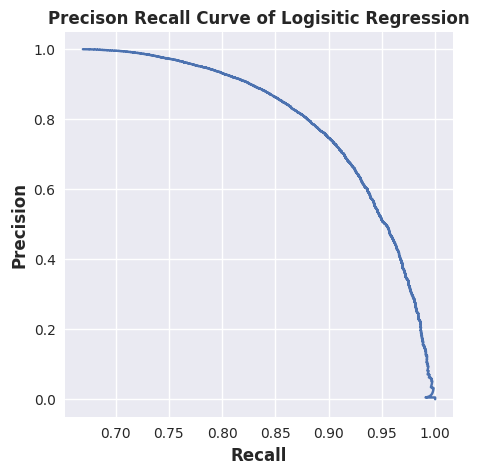

In [88]:
# plotting a Precision recall curve

precision, recall, thresh = precision_recall_curve(y_test_tf, lr_best_estimator.predict_proba(X_test_sparse)[:,1])

plt.figure(figsize=(5,5))
plt.plot(precision, recall)
plt.title('Precison Recall Curve of Logisitic Regression', fontweight='bold', fontsize=12)
plt.ylabel('Precision', fontweight='bold', fontsize=12)
plt.xlabel('Recall', fontweight='bold', fontsize=12);

In [89]:
print('PR AUC for Logisitic Regression:', auc(recall, precision))

PR AUC for Logisitic Regression: 0.930012523267129


### Insights

#### AUC score for PR curve alsmost same for ROC curve, it means our model is perfroming well.

# **Model 2: Linear SVC**

In [90]:
# keeping class weights as balanced for class imbalance

pipe_3 = Pipeline([
    ('svc_clf',LinearSVC(random_state=45, class_weight='balanced'))
])

pipe_3.fit(X_train_sparse, y_train_tf)  #runtime 47secs

Pipeline(steps=[('svc_clf',
                 LinearSVC(class_weight='balanced', random_state=45))])

In [91]:
print('f1-Score without any hyperparameter tunning:', f1_score(y_test_tf, pipe_3.predict(X_test_sparse), average='micro'))
print('Accuracy-Score without any hyperparameter tunning:', accuracy_score(y_test_tf, pipe_3.predict(X_test_sparse)))
print('Precision-Score without any hyperparameter tunning:', precision_score(y_test_tf, pipe_3.predict(X_test_sparse)))
print('Recall-Score without any hyperparameter tunning:', recall_score(y_test_tf, pipe_3.predict(X_test_sparse)))

f1-Score without any hyperparameter tunning: 0.7863418530351438
Accuracy-Score without any hyperparameter tunning: 0.7863418530351438
Precision-Score without any hyperparameter tunning: 0.8670394378742144
Recall-Score without any hyperparameter tunning: 0.8041303350160625


## Hyperparameter Tunning for Linear SVC

In [92]:
#  param_grid = {'svc_clf__C':[0.001, 0.1, 1, 100, 1000],
#               'svc_clf__max_iter':[15000,25000]}
              

# svc_clf_rs = RandomizedSearchCV(pipe_3, param_distributions = param_grid, cv=3, scoring='accuracy', n_jobs=-1, random_state=45)
# svc_clf_rs.fit(X_train_sparse, y_train_tf)   ##runtime 35 mins

In [93]:
# print('Best paramaters for Linear SVC are: ', svc_clf_rs.best_params_)

In [94]:
# svc_best_estimator = svc_clf_rs.best_estimator_ 
# cal_clf = CalibratedClassifierCV(svc_best_estimator)
# cal_clf.fit(X_train_sparse, y_train_tf)

In [95]:
print('Best parameters for the model are:',  {'max_iter' : 15000, 'C':0.1})

Best parameters for the model are: {'max_iter': 15000, 'C': 0.1}


In [96]:
svc_best_estimator = LinearSVC(random_state=45, class_weight='balanced', max_iter=15000, C=0.1)
cal_clf = CalibratedClassifierCV(svc_best_estimator)
cal_clf.fit(X_train_sparse, y_train_tf)

CalibratedClassifierCV(estimator=LinearSVC(C=0.1, class_weight='balanced',
                                           max_iter=15000, random_state=45))

In [97]:
print('f1-Score after hyperparameter tunning:', f1_score(y_test_tf, cal_clf.predict(X_test_sparse), average='micro'))
print('Accuracy-Score after hyperparameter tunning:', accuracy_score(y_test_tf, cal_clf.predict(X_test_sparse)))
print('Precision-Score after hyperparameter tunning:', precision_score(y_test_tf, cal_clf.predict(X_test_sparse)))
print('Recall-Score after hyperparameter tunning:', recall_score(y_test_tf, cal_clf.predict(X_test_sparse)))

f1-Score after hyperparameter tunning: 0.8060334234455641
Accuracy-Score after hyperparameter tunning: 0.8060334234455641
Precision-Score after hyperparameter tunning: 0.831221641982707
Recall-Score after hyperparameter tunning: 0.8911886186324002


## Confusion Matrix

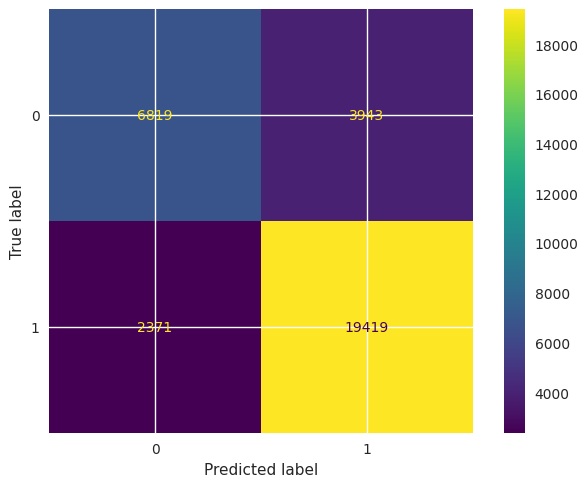

In [98]:
cm = ConfusionMatrixDisplay.from_predictions(y_test_tf, cal_clf.predict(X_test_sparse), cmap='viridis');

In [99]:
false_negatives = cm.confusion_matrix[1][0]
false_positives = cm.confusion_matrix[0][1]
true_negatives = cm.confusion_matrix[0][0]
true_positives = cm.confusion_matrix[1][1]
total = false_negatives + false_positives + true_negatives + true_positives
misclassification_rate = (false_negatives + false_positives)/total
classification_rate = (true_negatives + true_positives)/ total

print('Misclassification rate of the model: ', misclassification_rate)

Misclassification rate of the model:  0.19396657655443597


In [100]:
#plotting the learning curve for 5 training sizes with cv = 3


train_sizes, train_scores, test_scores = learning_curve(estimator= cal_clf , X = X_train_sparse, y=y_train_tf, 
                                                        train_sizes = np.linspace(0.1, 1, 5),scoring='accuracy',cv=3, n_jobs= -1) 

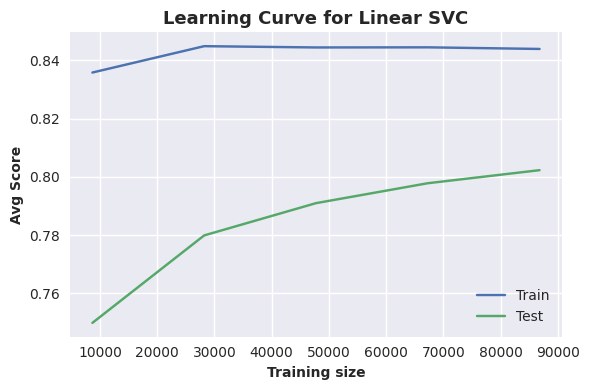

In [101]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, label='Train')
plt.plot(train_sizes, test_mean, label='Test')

plt.title('Learning Curve for Linear SVC', fontweight='bold', fontsize=13 )
plt.xlabel('Training size', fontweight='bold', fontsize=10)
plt.ylabel("Avg Score", fontweight='bold', fontsize=10)
plt.legend(loc='best')

plt.tight_layout();

## Insights

#### Model overfits in the beginning when training size is small, but eventually when training size increases model is able to generalize and is not fitting the noise. But in the end there is still some overfitting beacuse of difference between training and testing score.

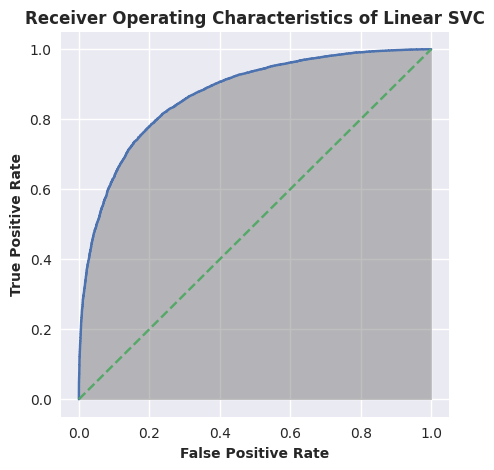

In [102]:
#plotting the ROC AUC

fpr,tpr, thresh = roc_curve(y_test_tf, cal_clf.predict_proba(X_test_sparse)[:,1])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.title('Receiver Operating Characteristics of Linear SVC', fontweight='bold', fontsize=12)
plt.fill_between(fpr, tpr, color='gray', alpha=0.5)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=10)
plt.xlabel('False Positive Rate',fontweight='bold', fontsize=10);

In [103]:
print('ROC AUC of Linear SVC: ', roc_auc_score(y_test_tf, cal_clf.predict_proba(X_test_sparse)[:,1]))

ROC AUC of Linear SVC:  0.8713051522622346


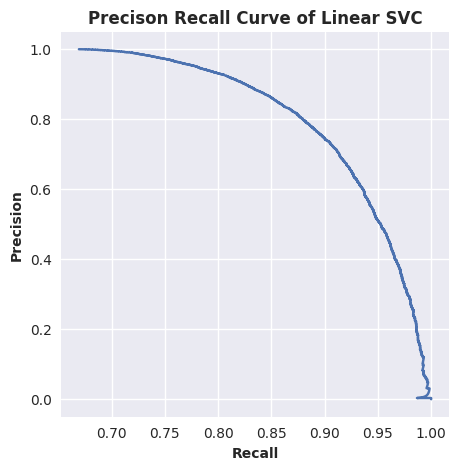

In [104]:
#plotting the Precision Recall curve

precision, recall, thresh = precision_recall_curve(y_test_tf, cal_clf.predict_proba(X_test_sparse)[:,1])

plt.figure(figsize=(5,5))
plt.plot(precision, recall)
plt.title('Precison Recall Curve of Linear SVC', fontweight='bold', fontsize=12)
plt.ylabel('Precision',fontweight='bold', fontsize=10)
plt.xlabel('Recall',fontweight='bold', fontsize=10);

In [105]:
print('PR AUC for Linear SVC:', auc(recall, precision))

PR AUC for Linear SVC: 0.9294841173756432


## Insights

#### Both PR AUC score and ROC AUC score are quite high which signifies that the model to able classify positives and negatives.

# **Model 3: XGBOOST**

In [106]:
# defining label_ratio for scale_pos_weight to handle class imbalance

labels_ratio = y_train.value_counts()['NEGATIVE']/ y_train.value_counts()['POSITIVE']

pipe_4 = Pipeline([
    ('xgb_clf', XGBClassifier(random_state=45, scale_pos_weight = labels_ratio, eval_metric='logloss'))
    ])

pipe_4.fit(X_train_sparse, y_train_tf)  #runtime 1:20 min

Pipeline(steps=[('xgb_clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=45, ...))])

In [107]:
print('f1-Score without any hyperparameter tunning:', f1_score(y_test_tf, pipe_4.predict(X_test_sparse), average='micro'))
print('Accuracy-Score without any hyperparameter tunning:', accuracy_score(y_test_tf, pipe_4.predict(X_test_sparse)))
print('Precision-Score without any hyperparameter tunning:', precision_score(y_test_tf, pipe_4.predict(X_test_sparse)))
print('Recall-Score without any hyperparameter tunning:', recall_score(y_test_tf, pipe_4.predict(X_test_sparse)))

f1-Score without any hyperparameter tunning: 0.7291410666011304
Accuracy-Score without any hyperparameter tunning: 0.7291410666011305
Precision-Score without any hyperparameter tunning: 0.8426028627264565
Recall-Score without any hyperparameter tunning: 0.7321248279027076


## Hyperparamter Tunning for XGBOOST

In [108]:
# param_grid = {
#     'xgb_clf__n_estimators': [50,150, 300],
#     'xgb_clf__learning_rate':[0.001, 0.1 , 1],
#     'xgb_clf__max_depth':[4, 7, 10]
# }

              
# xgb_clf_rs = RandomizedSearchCV(pipe_4, param_distributions = param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# xgb_clf_rs.fit(X_train_sparse, y_train_tf)   ##runtime 42 mins

In [109]:
# xgb_clf_rs.best_params_

In [110]:
# xgb_best_estimator = xgb_clf_rs.best_estimator_
# xgb_best_estimator.fit(X_train_sparse, y_train_tf) #runtime 3:25 mins

In [111]:
print('Best parameters for the model are: ', {'n_estimators':300, 'max_depth':10, 'learning_rate':1})

Best parameters for the model are:  {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 1}


In [112]:
xgb_best_estimator = XGBClassifier(random_state=45, scale_pos_weight = labels_ratio, eval_metric='logloss',
                                  n_estimators = 300, max_depth=10, learning_rate=1)

xgb_best_estimator.fit(X_train_sparse, y_train_tf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=45, ...)

In [113]:
print('f1-Score after hyperparameter tunning:', f1_score(y_test_tf, xgb_best_estimator.predict(X_test_sparse), average='micro'))
print('Accuracy-Score after hyperparameter tunning:', accuracy_score(y_test_tf, xgb_best_estimator.predict(X_test_sparse)))
print('Precision-Score after hyperparameter tunning:', precision_score(y_test_tf, xgb_best_estimator.predict(X_test_sparse)))
print('Recall-Score after hyperparameter tunning:', recall_score(y_test_tf, xgb_best_estimator.predict(X_test_sparse)))

f1-Score after hyperparameter tunning: 0.7659744408945686
Accuracy-Score after hyperparameter tunning: 0.7659744408945687
Precision-Score after hyperparameter tunning: 0.8472508085857101
Recall-Score after hyperparameter tunning: 0.7934373565855897


## Confusion Matrix

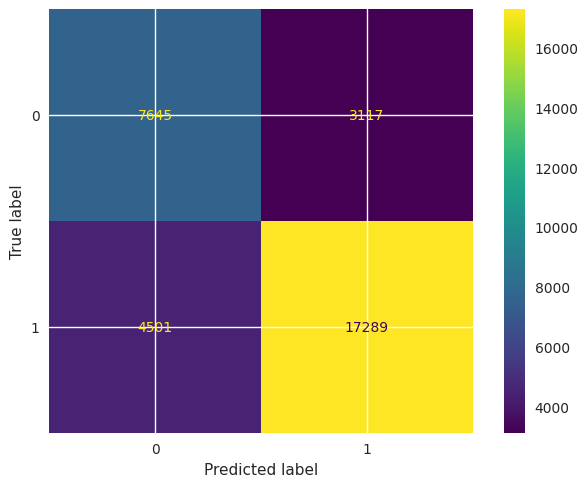

In [114]:
cm = ConfusionMatrixDisplay.from_predictions(y_test_tf, xgb_best_estimator.predict(X_test_sparse), cmap='viridis');

In [115]:
false_negatives = cm.confusion_matrix[1][0]
false_positives = cm.confusion_matrix[0][1]
true_negatives = cm.confusion_matrix[0][0]
true_positives = cm.confusion_matrix[1][1]
total = false_negatives + false_positives + true_negatives + true_positives
misclassification_rate = (false_negatives + false_positives)/total
classification_rate = (true_negatives + true_positives)/ total

print('Misclassification rate of the model: ', misclassification_rate)

Misclassification rate of the model:  0.2340255591054313


In [116]:
# plotting the learning curve for 3 training sizes with CV = 3

train_sizes, train_scores, test_scores = learning_curve(estimator= xgb_best_estimator, X = X_train_sparse, y=y_train_tf, 
                                                       scoring='accuracy' ,train_sizes = np.linspace(0.1, 1, 3), cv=3, n_jobs= -1) 

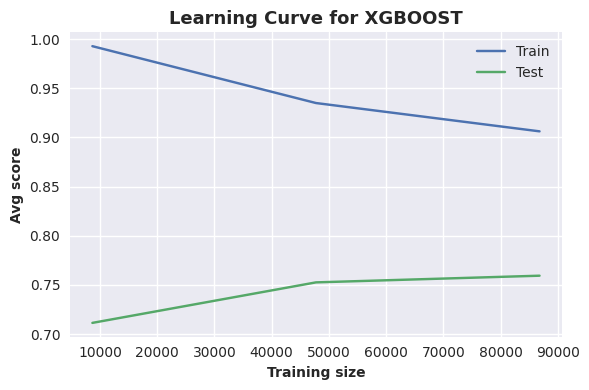

In [117]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, label='Train')
plt.plot(train_sizes, test_mean, label='Test')

plt.title('Learning Curve for XGBOOST', fontweight='bold', fontsize=13)
plt.xlabel('Training size', fontweight='bold', fontsize=10)
plt.ylabel('Avg score', fontweight='bold', fontsize=10)
plt.legend(loc='best')

plt.tight_layout();

## Insights

#### Intially with a small training size the model overfits, but as the training size increases the overfitting reduces as testing score increases and training score decreases. But still at the end model is not generalising very well.


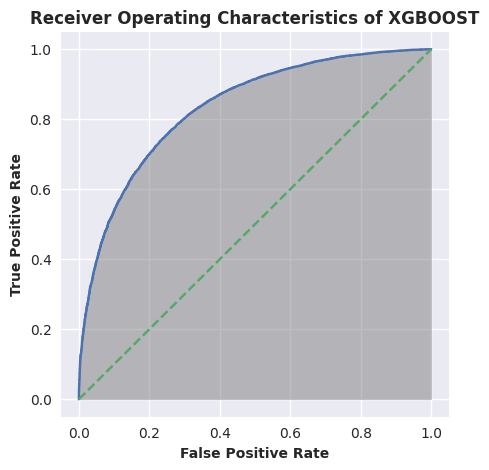

In [118]:
# plotting the ROC AUC

fpr,tpr, thresh = roc_curve(y_test_tf, xgb_best_estimator.predict_proba(X_test_sparse)[:,1])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.title('Receiver Operating Characteristics of XGBOOST', fontweight='bold', fontsize=12)
plt.fill_between(fpr, tpr, color='gray', alpha=0.5)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=10)
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=10);

In [119]:
print('ROC AUC of XGBOOST: ', roc_auc_score(y_test_tf, xgb_best_estimator.predict_proba(X_test_sparse)[:,1]))

ROC AUC of XGBOOST:  0.8340727415372652


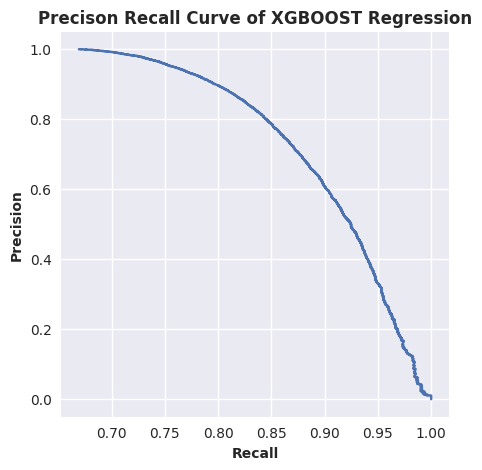

In [120]:
# plotting the Precision Recall curve

precision, recall, thresh = precision_recall_curve(y_test_tf, xgb_best_estimator.predict_proba(X_test_sparse)[:,1])

plt.figure(figsize=(5,5))
plt.plot(precision, recall)
plt.title('Precison Recall Curve of XGBOOST Regression', fontweight='bold', fontsize=12)
plt.ylabel('Precision',fontweight='bold', fontsize=10)
plt.xlabel('Recall', fontweight='bold', fontsize=10);

In [121]:
print('PR AUC for XGBOOST:', auc(recall, precision))

PR AUC for XGBOOST: 0.9047550229427329


## Insights

#### PR AUC and than ROC AUC are 0.90 and 0.82 respectively indicating that the model is able to distinguish between positive and negative classes.

# **Comparsion of the Performance of the three models**

## Scoring Metrics of different Models

In [122]:
model_metrics = {
    'Models_name': ['Logistic Regression', 'Linear SVC', 'XGBOOST'],
    'F1 Score before hpt':[0.791, 0.790, .731],
    'Accuracy Score before hpt' : [0.791, 0.790, 0.731],
    'Precision Score before hpt' : [0.879, 0.869, 0.844],
    'Recall Score before hpt' : [.798, 0.807, 0.735],
     'F1 Score after hpt':[0.795, 0.808, .761],
    'Accuracy Score after hpt' : [0.795, 0.808, 0.761],
    'Precision Score after hpt' : [0.882, 0.833, 0.839],
    'Recall Score after hpt' : [0.801,0.891 , 0.796],
    'Missclassification Rate': [0.20, 0.19 , 0.23],
    'ROC AUC': [0.876, 0.87,0.828],
    'PR AUC' :[ 0.931, 0.93,0.901]
}

pd.DataFrame(model_metrics)

Models_name  F1 Score before hpt  Accuracy Score before hpt  \
0  Logistic Regression                0.791                      0.791   
1           Linear SVC                0.790                      0.790   
2              XGBOOST                0.731                      0.731   

   Precision Score before hpt  Recall Score before hpt  F1 Score after hpt  \
0                       0.879                    0.798               0.795   
1                       0.869                    0.807               0.808   
2                       0.844                    0.735               0.761   

   Accuracy Score after hpt  Precision Score after hpt  \
0                     0.795                      0.882   
1                     0.808                      0.833   
2                     0.761                      0.839   

   Recall Score after hpt  Missclassification Rate  ROC AUC  PR AUC  
0                   0.801                     0.20    0.876   0.931  
1                   0.891                     0.19    0.870   0.930  
2                   0.796                     0.23    0.828   0.901

## Insights
#### 1. Hpt of logisitc regression does not much impact on improvement of any of the scores.
#### 2. Hpt of Linear SVC does increase F1 , Accuracy score and Recall score by a small amount.But it also decreases the precision score.
#### 3. Hpt of XGBOOST seems to have the biggest increase on the improvement of all the scores out of all the models.
#### 4. Misclassification rate of all the three models is almost the same around 20 percent.
#### 5. Logisitic Regression has the highest ROC AUC score as PR AUC score.

## Runtime of Different Models

In [123]:
model_time = {
    'Models_name': ['Logistic Regression', 'Linear SVC', 'XGBOOST'],
    'Time taken to fit the model (secs)' : [8, 47, 45],
    'Time taken for hpt (mins)' : [15, 34, 42]
}

pd.DataFrame(model_time)

Models_name  Time taken to fit the model (secs)  \
0  Logistic Regression                                   8   
1           Linear SVC                                  47   
2              XGBOOST                                  45   

   Time taken for hpt (mins)  
0                         15  
1                         34  
2                         42

## Insights

#### 1. Logistic Regression is fastest model out of the models in terms of fitting the data as well as hpt.
#### 2. On the other hand, Linear SVC is the slowest in fitting the data as well as hpt.

# **Choosing the Final Model**

### We will be working with Logistic Regression as our final model

In [124]:
merged_train_df.head()

movieid  audienceScore  runtimeMinutes originalLanguage  \
0  james_bond_courageous      49.333333            82.2          English   
1  james_bond_courageous      49.333333            82.2          English   
2  james_bond_courageous      49.333333            82.2          English   
3  james_bond_courageous      49.333333            82.2          English   
4  james_bond_courageous      49.333333            82.2          English   

   genre   director    reviewerName  isFrequentReviewer  \
0  Drama  Brian Mew  Karen Hamilton               False   
1  Drama  Brian Mew    Jessica Best               False   
2  Drama  Brian Mew   Rebekah Gomez               False   
3  Drama  Brian Mew   Paul Sullivan               False   
4  Drama  Brian Mew   Stacey Malone                True   

                                          reviewText sentiment  
0  This is nowhere near the level of other great ...  POSITIVE  
1  If you're feeling adventurous and looking for ...  POSITIVE  
2  Mercifully, Vincent Cassel provides a strong l...  POSITIVE  
3  Like the storm that destroys the best laid pla...  POSITIVE  
4  Less a proper coming-of-age movie than a posh ...  NEGATIVE

In [125]:
final_X_train = merged_train_df.drop(columns=['movieid','originalLanguage', 'director', 'reviewerName', 'sentiment', 'genre'])
final_y_train = merged_train_df['sentiment']
final_X_train.head()

audienceScore  runtimeMinutes  isFrequentReviewer  \
0      49.333333            82.2               False   
1      49.333333            82.2               False   
2      49.333333            82.2               False   
3      49.333333            82.2               False   
4      49.333333            82.2                True   

                                          reviewText  
0  This is nowhere near the level of other great ...  
1  If you're feeling adventurous and looking for ...  
2  Mercifully, Vincent Cassel provides a strong l...  
3  Like the storm that destroys the best laid pla...  
4  Less a proper coming-of-age movie than a posh ...

In [126]:
merged_test_df.head()

movieid  audienceScore  runtimeMinutes  \
0                   james_bond_courageous      49.333333            82.2   
1                   james_bond_courageous      49.333333            82.2   
2  jack_torrance_the_joker_luke_skywalker            NaN            98.0   
3                    ellis_redding_silent      61.000000            90.0   
4                    ellis_redding_silent      61.000000            90.0   

  originalLanguage        genre     director       reviewerName  isTopCritic  \
0          English        Drama    Brian Mew     Elijah Mercado        False   
1          English        Drama    Brian Mew     Andrew Holland        False   
2          English        Drama   Lewis Horn       Dale Montoya        False   
3          English  Documentary  Lee Dykstra  Karina Dalton DVM         True   
4          English  Documentary  Lee Dykstra     Kenneth Parker         True   

                                          reviewText  
0  In the efficient opening scene of Adrift's tru...  
1                ADRIFT ended up just feeling small.  
2  Highly uneven and inconsistent ... Margarita H...  
3                                                NaN  
4  It feels warmed over, devoid of urgency and, i...

In [127]:
final_X_test = merged_test_df.drop(columns=['movieid','originalLanguage', 'director', 'reviewerName', 'genre'])
final_X_test.rename(columns = {'isTopCritic':'isFrequentReviewer'}, inplace=True)
final_X_test.head()

audienceScore  runtimeMinutes  isFrequentReviewer  \
0      49.333333            82.2               False   
1      49.333333            82.2               False   
2            NaN            98.0               False   
3      61.000000            90.0                True   
4      61.000000            90.0                True   

                                          reviewText  
0  In the efficient opening scene of Adrift's tru...  
1                ADRIFT ended up just feeling small.  
2  Highly uneven and inconsistent ... Margarita H...  
3                                                NaN  
4  It feels warmed over, devoid of urgency and, i...

In [128]:
# fitting the pipeline defined for preprocessing

final_X_train_tf = pipe_1.fit_transform(final_X_train)
final_X_test_tf = pipe_1.transform(final_X_test)

In [129]:
# imputing the missing values in the reviewText column 

imputer = SimpleImputer(strategy='most_frequent')
reviewText_train_final = imputer.fit_transform(final_X_train[['reviewText']]).flatten()
reviewText_test_final= imputer.transform(final_X_test[['reviewText']]).flatten()

# vectorizing the reviewText column using Tfidf vectorizer

vec = TfidfVectorizer(lowercase=True, stop_words=list(ENGLISH_STOP_WORDS))
reviewText_train_final_tf = vec.fit_transform(reviewText_train_final)
reviewText_test_final_tf = vec.transform(reviewText_test_final)

In [130]:
X_train_sparse_final = sparse.hstack([final_X_train_tf, reviewText_train_final_tf])
X_test_sparse_final = sparse.hstack([final_X_test_tf, reviewText_test_final_tf])

In [131]:
print('Shape of X_train_sparse:', X_train_sparse_final.shape)
print('Shape of X_test_sparse:', X_test_sparse_final.shape)

Shape of X_train_sparse: (162758, 64915)
Shape of X_test_sparse: (55315, 64915)


In [132]:
final_pipe = Pipeline([
    ('lr_clf', LogisticRegression(random_state=45))
])

final_pipe.fit(X_train_sparse_final, final_y_train) 


Pipeline(steps=[('lr_clf', LogisticRegression(random_state=45))])

In [133]:
y_pred = final_pipe.predict(X_test_sparse_final)

In [134]:
submission = pd.DataFrame(columns =['id', 'sentiment'])
submission['id'] = [i for i in range(len(y_pred))]
submission['sentiment'] = y_pred

In [135]:
submission.to_csv('submission.csv', index=False)